# 0.0. IMPORTS

In [1]:
import pandas as pd
import inflection
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import HTML
from IPython.display import Image 


## 0.1. Helper Functions

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

In [3]:
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## 0.2. Loading Data

In [4]:
df_sales_raw = pd.read_csv('data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('data/store.csv', low_memory=False)

# Merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

In [5]:
df_raw.sample()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
409970,436,7,2014-06-29,0,0,0,0,0,0,d,a,2300.0,NaN,NaN,0,NaN,NaN,NaN


# 1.0. PASSO 01 - DESCRICAO DOS DADOS

## 1.1. Rename Columns

In [6]:
# Copia do Dataframe
df1 = df_raw.copy()

In [7]:
# Nome antigo das colunas
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
            'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
            'CompetitionDistance', 'CompetitionOpenSinceMonth',
            'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
            'Promo2SinceYear', 'PromoInterval']

# Função para ajusar o nome das colunas
snakecase = lambda x: inflection.underscore( x )
cols_new = list(map(snakecase, cols_old))

# Renomear as colunas do Dataframe
df1.columns = cols_new


## 1.2. Data Dimensions

In [8]:
print('Numer of Rows: {}'.format(df1.shape[0]))
print('Numer of Columns: {}'.format(df1.shape[1]))

Numer of Rows: 1017209
Numer of Columns: 18


## 1.3. Data Types

In [9]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. Check NA

In [10]:
# Verificar quantas features temos com dados NA
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5. Fillout NA

Tratamento dos dados Faltantes
- Avaliar cada um dos casos e propor uma melhor solução para o tratamento desses dados:
    - competition_distance - distance in meters to the nearest competitor store
    - competition_open_since_month-  gives the approximate month of the time the nearest competitor was opened
    - competition_open_since_year -  gives the approximate year of the time the nearest competitor was opened
    - promo2_since_week - describes calendar week when the store started participating in Promo2
    - promo2_since_year - describes the year when the store started participating in Promo2
    - promo_interval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g


Possibilidades para o tratamento dos NA
 - 1. Excluir os dados com NA (vantagem é ser muito rápido para executar, desvantagem perde-se muita informação)
 - 2. Usar algoritmos de Machine Learning para fazer a substituição conforme o comportamento da coluna (aplicar média, ou mediana, aplicar o valor conforme a clusterização)
 - 3. Pensar como o negócio, refletir o porque esse NA foi gerado e seguir tratando cada um dos casos.

#### competition_distance

**Assumptions**:
 - A coluna está com NA devido não ter competir próximo ou se existe competidor ele está muito distante dessa loja.
 - Realizar a inclusão de um valor que representa essa inexistência ou irrelevância por estar muito distante

In [11]:
# Verificar o maior valor referente a essa feature
df1['competition_distance'].max()

75860.0

In [12]:
# Realizar o input do valor de 200000 nos valores faltantes
df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 2000000.0 if math.isnan(x) else x )

#### competition_open_since_month

**Assumptions**:
 - Iremos inferir que essa coluna possui dados faltantes devido a loja não temos um competidor mais próximo, a loja tem um competidor mais próximo, mas não sabe quando foi aberto, ou porque esse competidor abriu muito antes da loja ser aberta ou o competidor abriu depois e esqueceram de anotar
 - Seguiremos com o processo de copiar a data da venda dessa linha especifica que possui o dado NA, claro extrair o mês dessa data de venda.


In [13]:
df1['competition_open_since_month'] = df1.apply(
                                                lambda x: x['date'].month if math.isnan(x['competition_open_since_month'])
                                                else x['competition_open_since_month'], axis=1)

#### competition_open_since_year

**Assumptions**:
 - Iremos inferir que essa coluna possui dados faltantes devido a loja não temos um competidor mais próximo, a loja tem um competidor mais próximo, mas não sabe quando foi aberto, ou porque esse competidor abriu muito antes da loja ser aberta ou o competidor abriu depois e esqueceram de anotar
 - Seguiremos com o processo de copiar a data da venda dessa linha especifica que possui o dado NA, claro extrair o ano dessa data de venda.


In [14]:
df1['competition_open_since_year'] = df1.apply(
                                                lambda x: x['date'].year if math.isnan(x['competition_open_since_year'])
                                                else x['competition_open_since_year'], axis=1)

#### promo2_since_week

**Assumptions**:
 - Iremos inferir que essa coluna possui dados faltantes devido a loja em questão não decidiu participar dessa promoção.
 - Seguiremos a mesma estratégia adotada anteriormente criando uma cópia da data da venda dessa linha especifica que possui o dado NA, claro extrair a semana dessa data de venda.

In [15]:
df1['promo2_since_week'] = df1.apply(
                                    lambda x: x['date'].week if math.isnan(x['promo2_since_week'])
                                    else x['promo2_since_week'], axis=1)

#### promo2_since_year

**Assumptions**:
 - Iremos inferir que essa coluna possui dados faltantes devido a loja em questão não decidiu participar dessa promoção.
 - Seguiremos a mesma estratégia adotada anteriormente criando uma cópia da data da venda dessa linha especifica que possui o dado NA, claro extrair o ano dessa data de venda.

In [16]:
df1['promo2_since_year'] = df1.apply(
                                    lambda x: x['date'].year if math.isnan(x['promo2_since_year'])
                                    else x['promo2_since_year'], axis=1)

#### promo_interval

**Assumptions**:
 - Seguiremos a mesma estratégia adotada anteriormente.
 - Realizar um split dessa coluna e criar uma lista e verificar se o mês dessa data estiver dentro da lista a promo2 estava ativa.

In [17]:
# Verificação dos dados únicos da coluna promo_interval
df1['promo_interval'].unique()

array([nan, 'Jan,Apr,Jul,Oct', 'Feb,May,Aug,Nov', 'Mar,Jun,Sept,Dec'],
      dtype=object)

In [18]:
# Criar um dicionário com o número do mês e sua abreviação
month_map = {
1: 'Jan',
2: 'Feb',
3: 'Mar',
4: 'Apr',
5: 'May',
6: 'Jun',
7: 'Jul',
8: 'Aug',
9: 'Sept',
10: 'Oct',
11: 'Nov',
12: 'Dec'
}

In [19]:
# Preencher os valores NA da coluna promo_interval com Zero
df1['promo_interval'].fillna(0, inplace = True)

# Criar uma coluna month_map
df1['month_map'] = df1['date'].dt.month.map(month_map)

In [20]:
# Verificar o resultado parcial, se a coluna foi criada seguinte o mapeamento do mês de acordo com o dicionário criado
df1.sample(5).T

,284819,626776,639172,335057,200366
store,906,932,1063,599,782
day_of_week,1,2,5,3,1
date,2014-11-10 00:00:00,2013-12-17 00:00:00,2013-12-06 00:00:00,2014-09-17 00:00:00,2015-02-02 00:00:00
sales,11591,13274,4356,9693,6967
customers,1400,1122,552,840,614
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,0,0,0,0,0
school_holiday,0,0,0,0,0
store_type,a,a,a,d,c


In [21]:
# Realizar um split baseado na virgula (',') nesse array da coluna promo_interval
df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

In [22]:
# Verificar o resultado
df1.sample(5).T

,250071,392187,585565,64812,127948
store,726,722,976,143,839
day_of_week,3,5,4,3,3
date,2014-12-17 00:00:00,2014-07-18 00:00:00,2014-01-23 00:00:00,2015-06-03 00:00:00,2015-04-08 00:00:00
sales,20014,8749,6782,8589,3753
customers,1522,1551,713,714,528
open,1,1,1,1,1
promo,1,1,1,1,0
state_holiday,0,0,0,0,0
school_holiday,0,0,0,0,1
store_type,a,a,a,d,c


## 1.6. Change Types

In [23]:
# Transformar variáveis float para int
# Não faz sentido essas variáveis estarem como float pois são int
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype('int64')
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype('int64')
df1['promo2_since_week'] = df1['promo2_since_week'].astype('int64')
df1['promo2_since_year'] = df1['promo2_since_year'].astype('int64')

## 1.7. Descriptive Statistical

In [24]:
# Separar em variáveis numéricas e variáveis categoricas
num_attributes = df1.select_dtypes(include = ['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude = ['int64', 'float64', 'datetime64[ns]'])

### 1.7.1. Numerical Attributes

In [25]:
# Central Tendency
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# Concatenat
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()

# Nomear as Colunas
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,2000000.0,1999980.0,10610.588099,2330.0,101810.649100,19.378002,375.644405
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


Text(0, 0.5, 'Densidade')

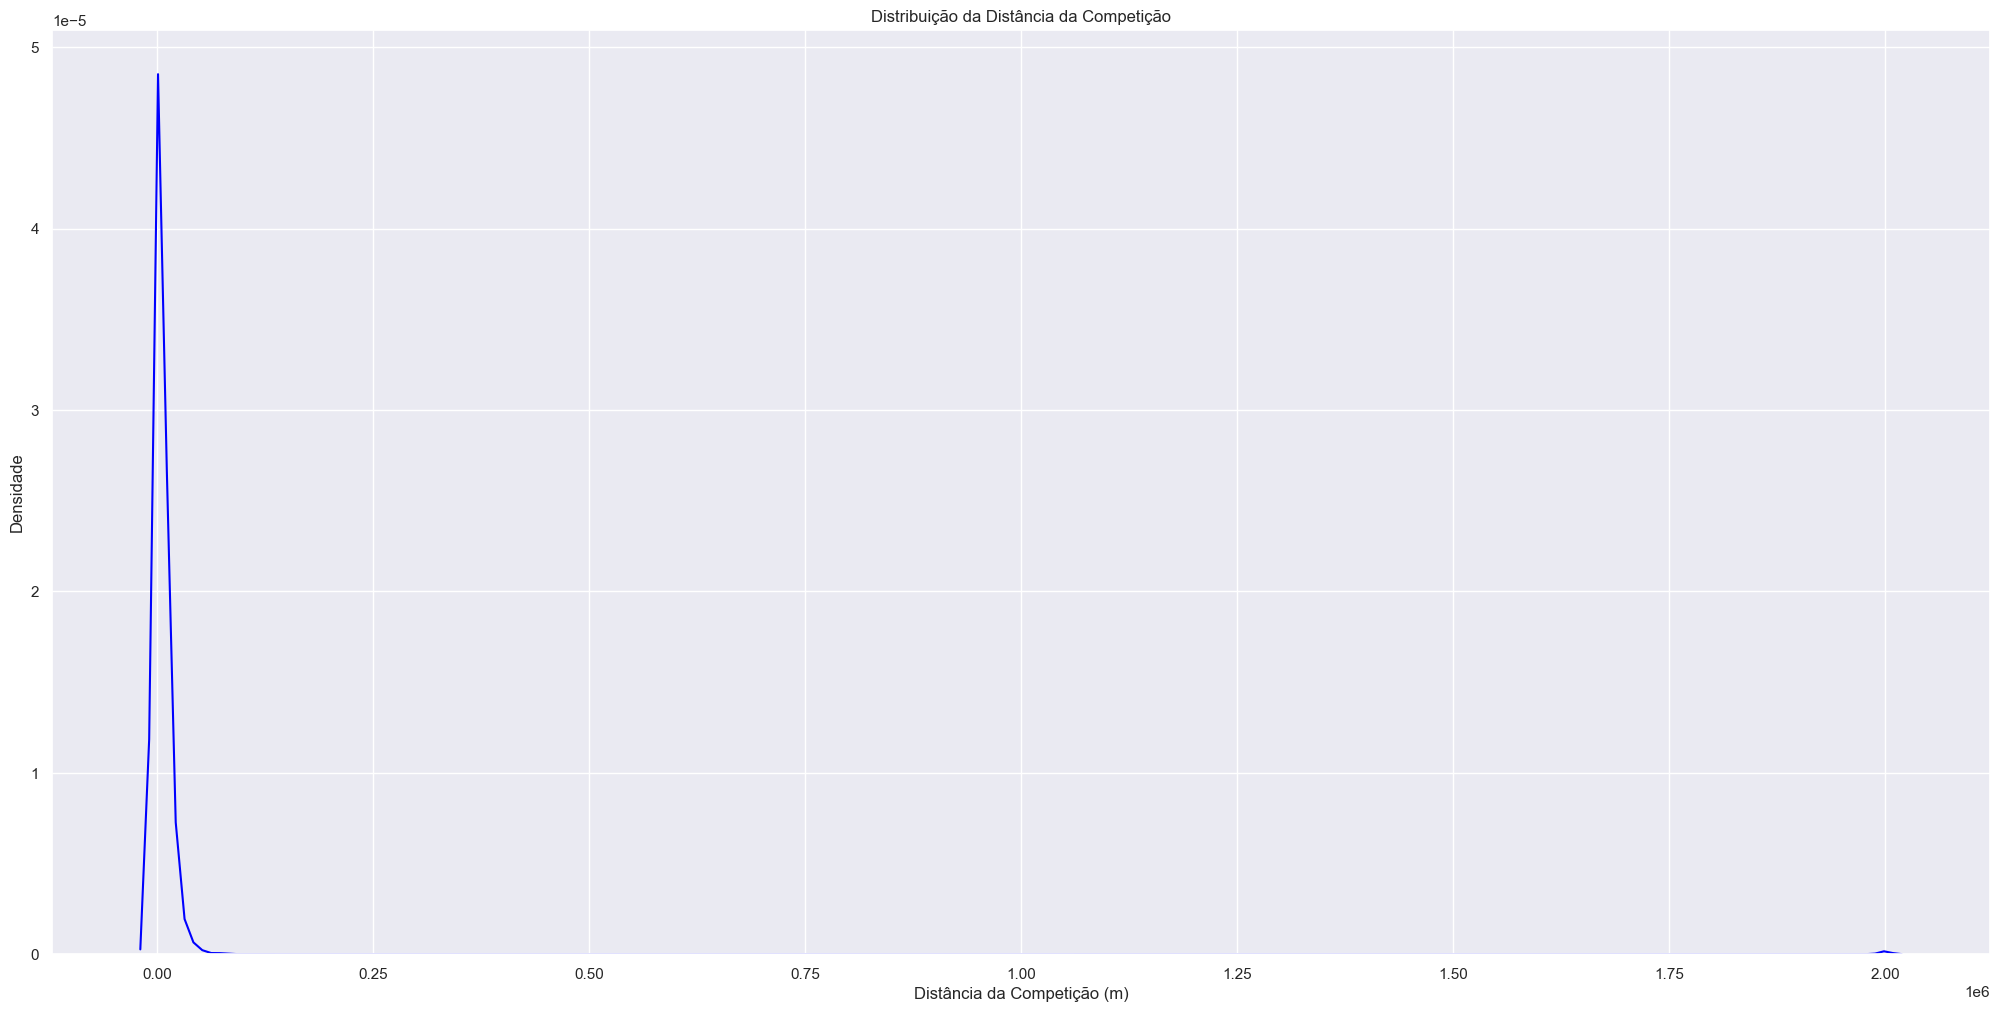

In [26]:
sns.kdeplot(df1['competition_distance'], color='blue')
plt.title('Distribuição da Distância da Competição')
plt.xlabel('Distância da Competição (m)')
plt.ylabel('Densidade')

### 1.7.2. Categorical Attriburtes

In [27]:
# Identificar a quantidade de variaveis
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<Axes: xlabel='assortment', ylabel='sales'>

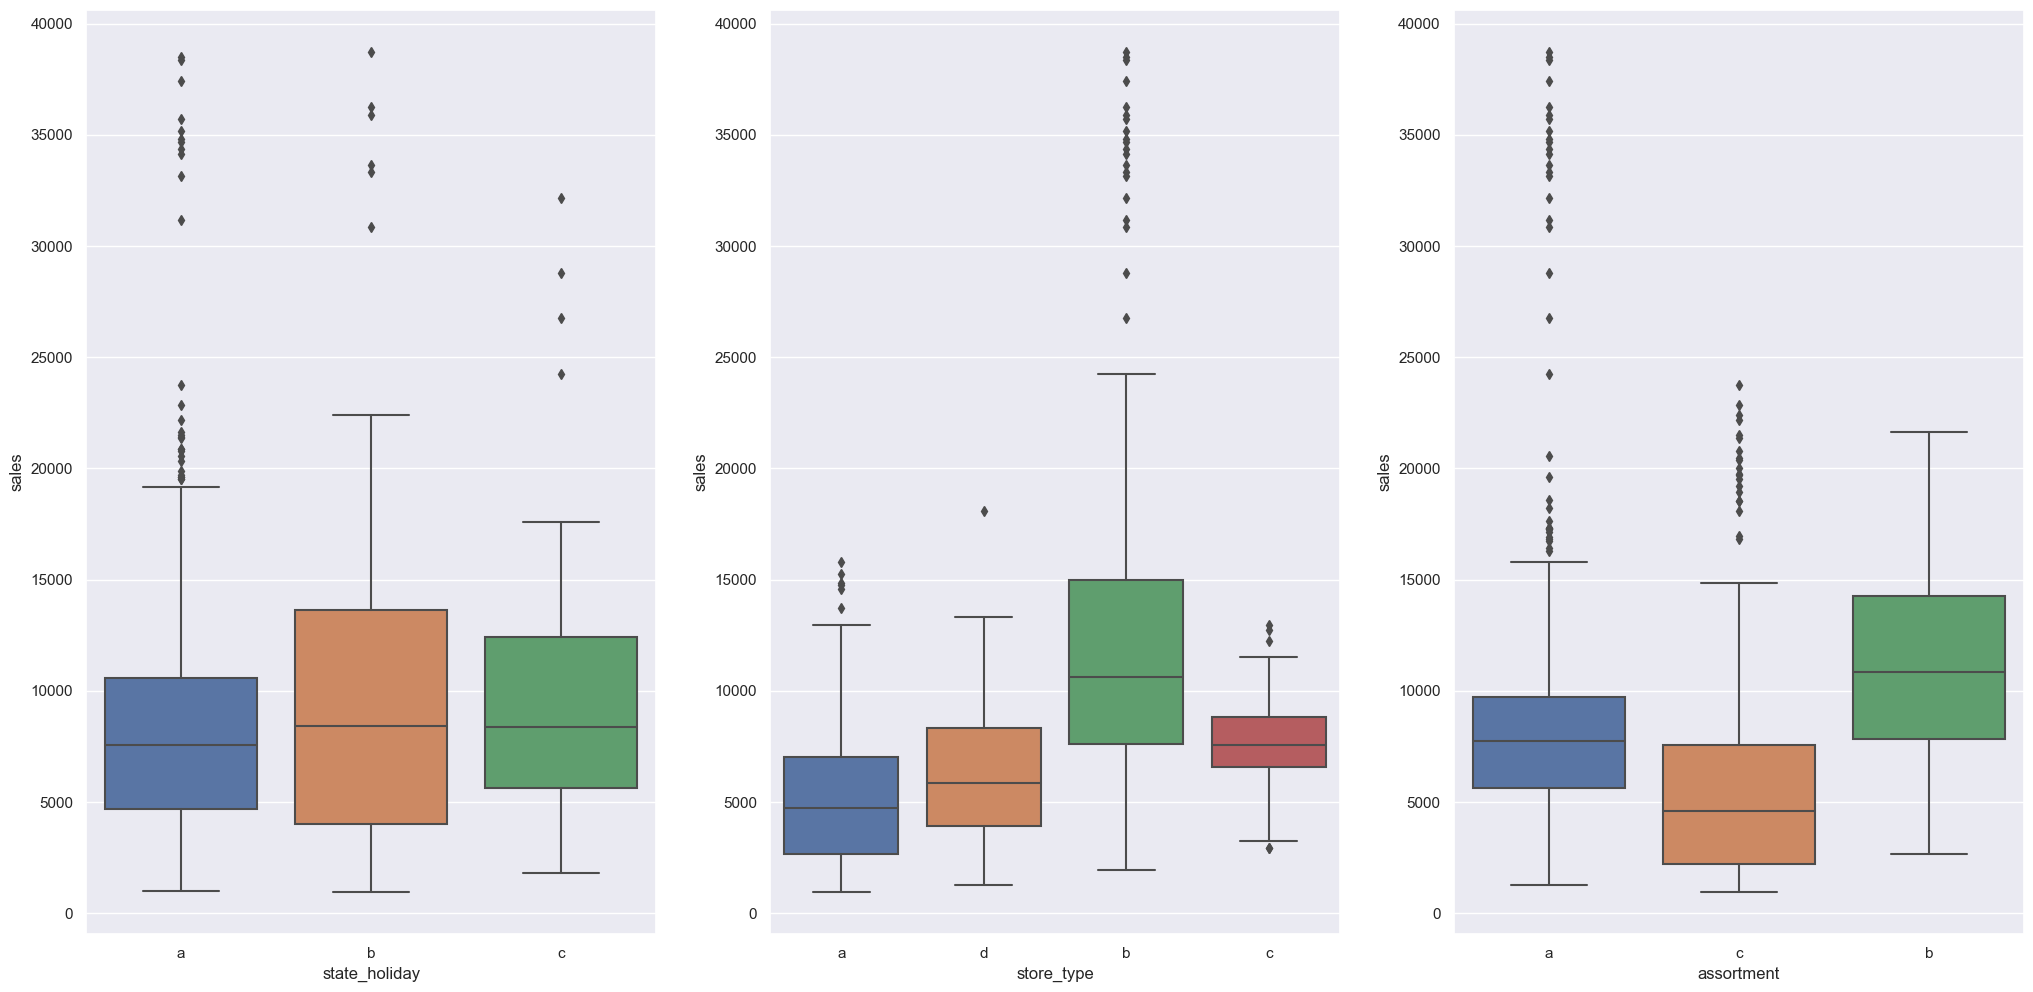

In [28]:
# Necessidade filtrar as datas retirando os dias que as lojas estão fechadas e vendas maiores que zero
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] >0 )]

# Plotar um box-plot ao lado do outro (plt.subplot( linhas, colunas, posição))
plt.subplot(1, 3, 1)
sns.boxplot(x='state_holiday', y='sales', data=aux1)

plt.subplot(1, 3, 2)
sns.boxplot(x='store_type', y='sales', data=aux1)

plt.subplot(1, 3, 3)
sns.boxplot(x='assortment', y='sales', data=aux1)


# 2.0. PASSO 02 - FEATURE ENGINEERING

In [29]:
df2 = df1.copy()

## 2.1. MINDMAP HYPOTHESES

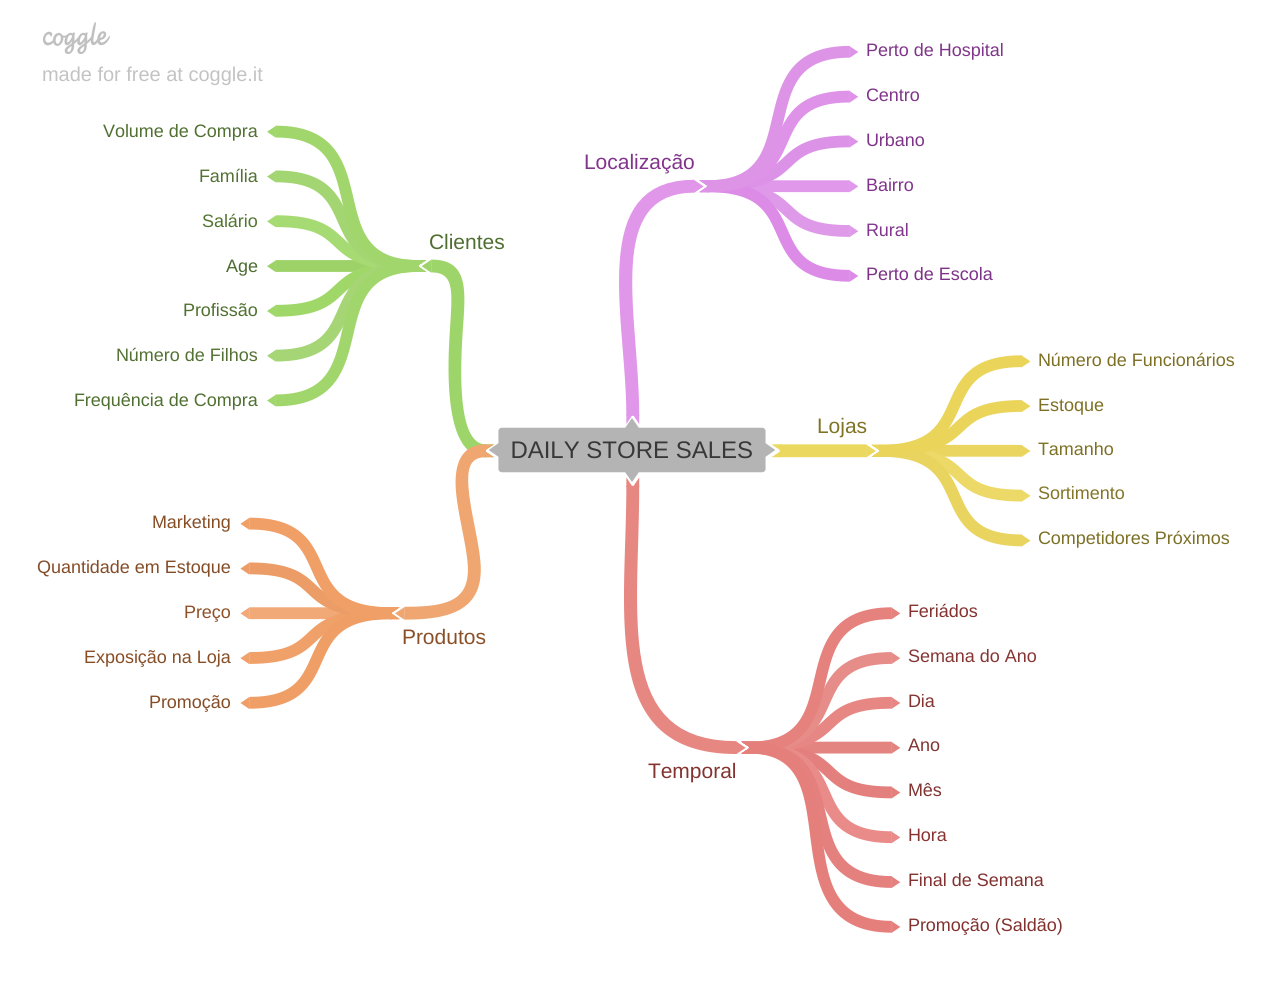

In [30]:
# Classe image para importar o mapa mental
Image('img/MindMapHypotheses.png')

## 2.2. HYPOTHESES CREATION

### 2.1.1. Stores Hypothesis

**1.** Lojas com número maior de funcionários deveriam vender mais.

**2.** Lojas com maior capacidade de estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com maior sortimentos deveriam vender mais.

**5.** Lojas com competidores mais próximos deveriam vender menos.

**6.** Lojas com competidores à mais tempo deveriam vendem mais.

### 2.1.2. Product Hypothesis

**1.** Lojas que investem mais em Marketing deveriam vender mais.

**2.** Lojas com maior exposição de produto deveriam vender mais.

**3.** Lojas com produtos com preço menor deveriam vender mais.

**5.** Lojas com promoções mais agressivas ( descontos maiores ), deveriam vender mais.

**6.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**7.** Lojas com mais dias de promoção deveriam vender mais.

**8.** Lojas com mais promoções consecutivas deveriam vender mais.

### 2.1.3. Temporal Hypothesis

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo dos anos.

**3.** Lojas deveriam vender mais no segundo semestre do ano.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**5.** Lojas deveriam vender menos aos finais de semana.

**6.** Lojas deveriam vender menos durante os feriados escolares.

## 2.3. FINAL LIST HYPOTHESES

**1.** Lojas com maior sortimentos deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos.

**3.** Lojas com competidores à mais tempo deveriam vendem mais.

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais.

**6.** Lojas com mais promoções consecutivas deveriam vender mais.

**7.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**8.** Lojas deveriam vender mais ao longo dos anos.

**9.** Lojas deveriam vender mais no segundo semestre do ano.

**10.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**11.** Lojas deveriam vender menos aos finais de semana.

**12.** Lojas deveriam vender menos durante os feriados escolares.

## 2.4. FEATURE ENGINEERING

In [31]:
# year
# transforma em datatime (dt) e usa o metodo .year
df2['year'] = df2['date'].dt.year

# month
# transforma em datatime (dt) e usa o metodo .month
df2['month'] = df2['date'].dt.month

# day
# transforma em datatime (dt) e usa o metodo .day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week

# year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# competition since
# cria coluna competition_since, fazendo a união atravez do método datetime.datetime
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year = x['competition_open_since_year'] , month= x['competition_open_since_month'], day=1), axis = 1)
#faz a diferença das colunas date e competition_since - para obter o tempo de promoção em mes
df2['competition_time_month'] = ((df2['date'] - df2['competition_since']) / 30).apply(lambda x: x.days).astype(int)

# promo since
# Realizar o join nos caracteres, importante que as duas veriáveis sejam strings converter com .astype(str)
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
# Converter para uma data com o método .strptime(), somar -1 e colocar o formato de resultado '%Y-%W-%w' (Ano - Semana do Ano - Semana (dom à dom))
# Utilizar o método time delta para substituir 7 dias dessa nova data. Não é necessário usar o axis=1 por ser aplicado somente em uma coluna
df2['promo_since']= df2['promo_since'].apply(lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w') - datetime.timedelta(days = 7))
# Subtrair as datas
df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)

# assortment
# Incluir os níveis
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

# state holiday
# Substituir conforme os significados dos feriados
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

In [32]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3.0. PASSO 03 - VARIABLE FILTERING

In [33]:
df3 = df2.copy()

In [34]:
df3.apply(lambda x: x.unique().shape[0])

store                            1115
day_of_week                         7
date                              942
sales                           21734
customers                        4086
open                                2
promo                               2
state_holiday                       4
school_holiday                      2
store_type                          4
assortment                          3
competition_distance              655
competition_open_since_month       12
competition_open_since_year        23
promo2                              2
promo2_since_week                  52
promo2_since_year                   7
promo_interval                      4
month_map                          12
is_promo                            2
year                                3
month                              12
day                                31
week_of_year                       52
year_week                         137
competition_since                 173
competition_

## 3.1. ROW FILTERING

In [35]:
# open igual a zero signifca que a loja esteva fechada, nesse caso não possibilita aprendizado nenhum, não sendo uma necessários os registro de open == 0
# quando temos uma loja fechada, o valor de sales é igual a zero, não sendo necessários esse registros quando open == 0

df3 = df3[(df3['open'] != 0)  & (df3['sales'] > 0)]

## 3.2. COLUMNS SELECTION

In [36]:
# customers (essa feature não está disponível no momento da predição)
# após a filtragem das linhas, a coluna open está com valores igual a 1, não sendo mais necessária para próximas etapas
# dropar as colunas auxliares (promo_interval, month_map) que foram usadas para derivar features

# criar uma lista com as colunas que serão dropadas
cols_drop = ['customers', 'open', 'promo_interval', 'month_map'] 

# Realizar o drop das colunas
df3 = df3.drop(cols_drop, axis=1)

# 4.0. PASSO 04 - EXPLORATORY DATA ANALYSIS

In [37]:
df4 = df3.copy()

## 4.1. UNIVARIATE ANALYSIS

### 4.1.1. RESPONSE VARIABLE

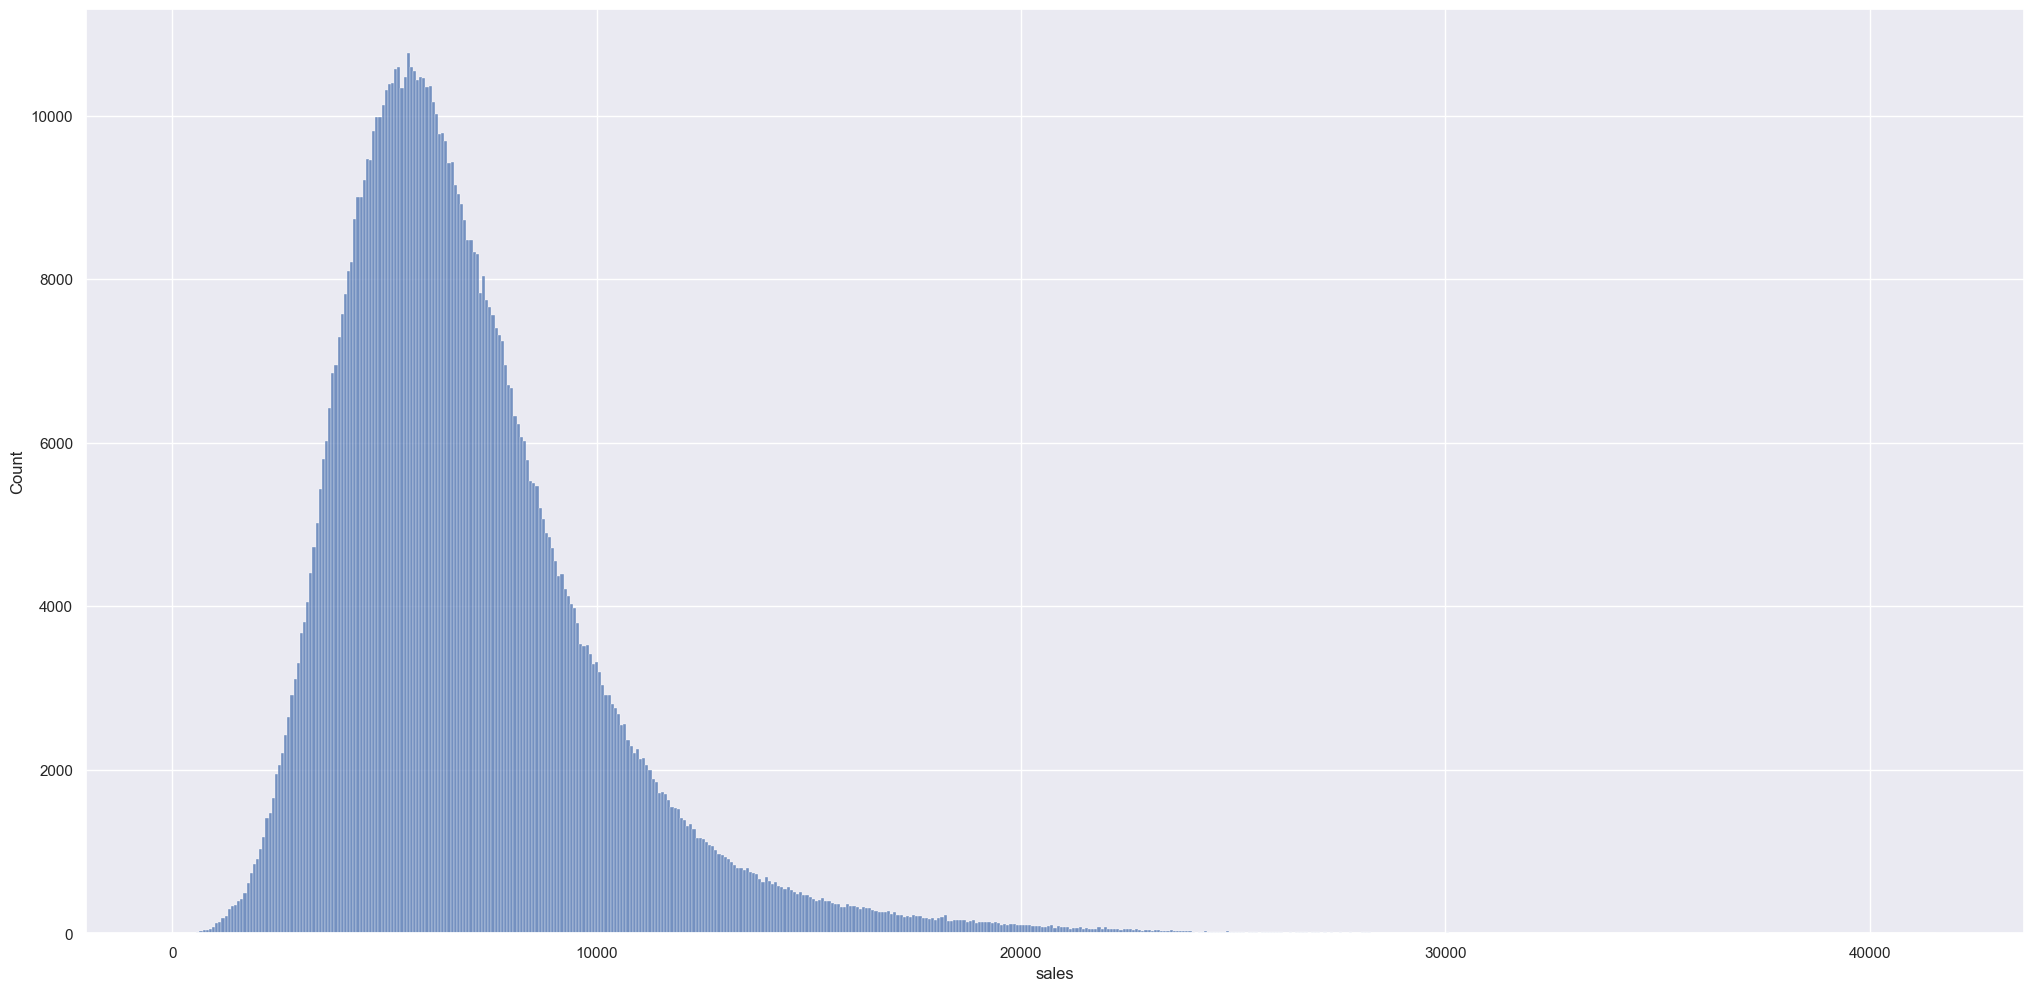

In [38]:
# Plotagem da duistribuição da variável sales
# Em formato de sino, tem curtose, deslocada para a esquedar, próximo a uma normal.
sns.histplot(df4['sales'], kde=False);

In [39]:
# Algoritimos de ML são criado baseados em algumas premissas de comportamento dos dados (que o dado seja independente e que sejam normalmente distribuidos.
# Quanto mas normal for sua resposta, melhor seu algoritmo irá performar, podendo ser aplicados técnicas de transformações para transformar a distribuição
# de uma variável resposta o mais próximo a uma normal

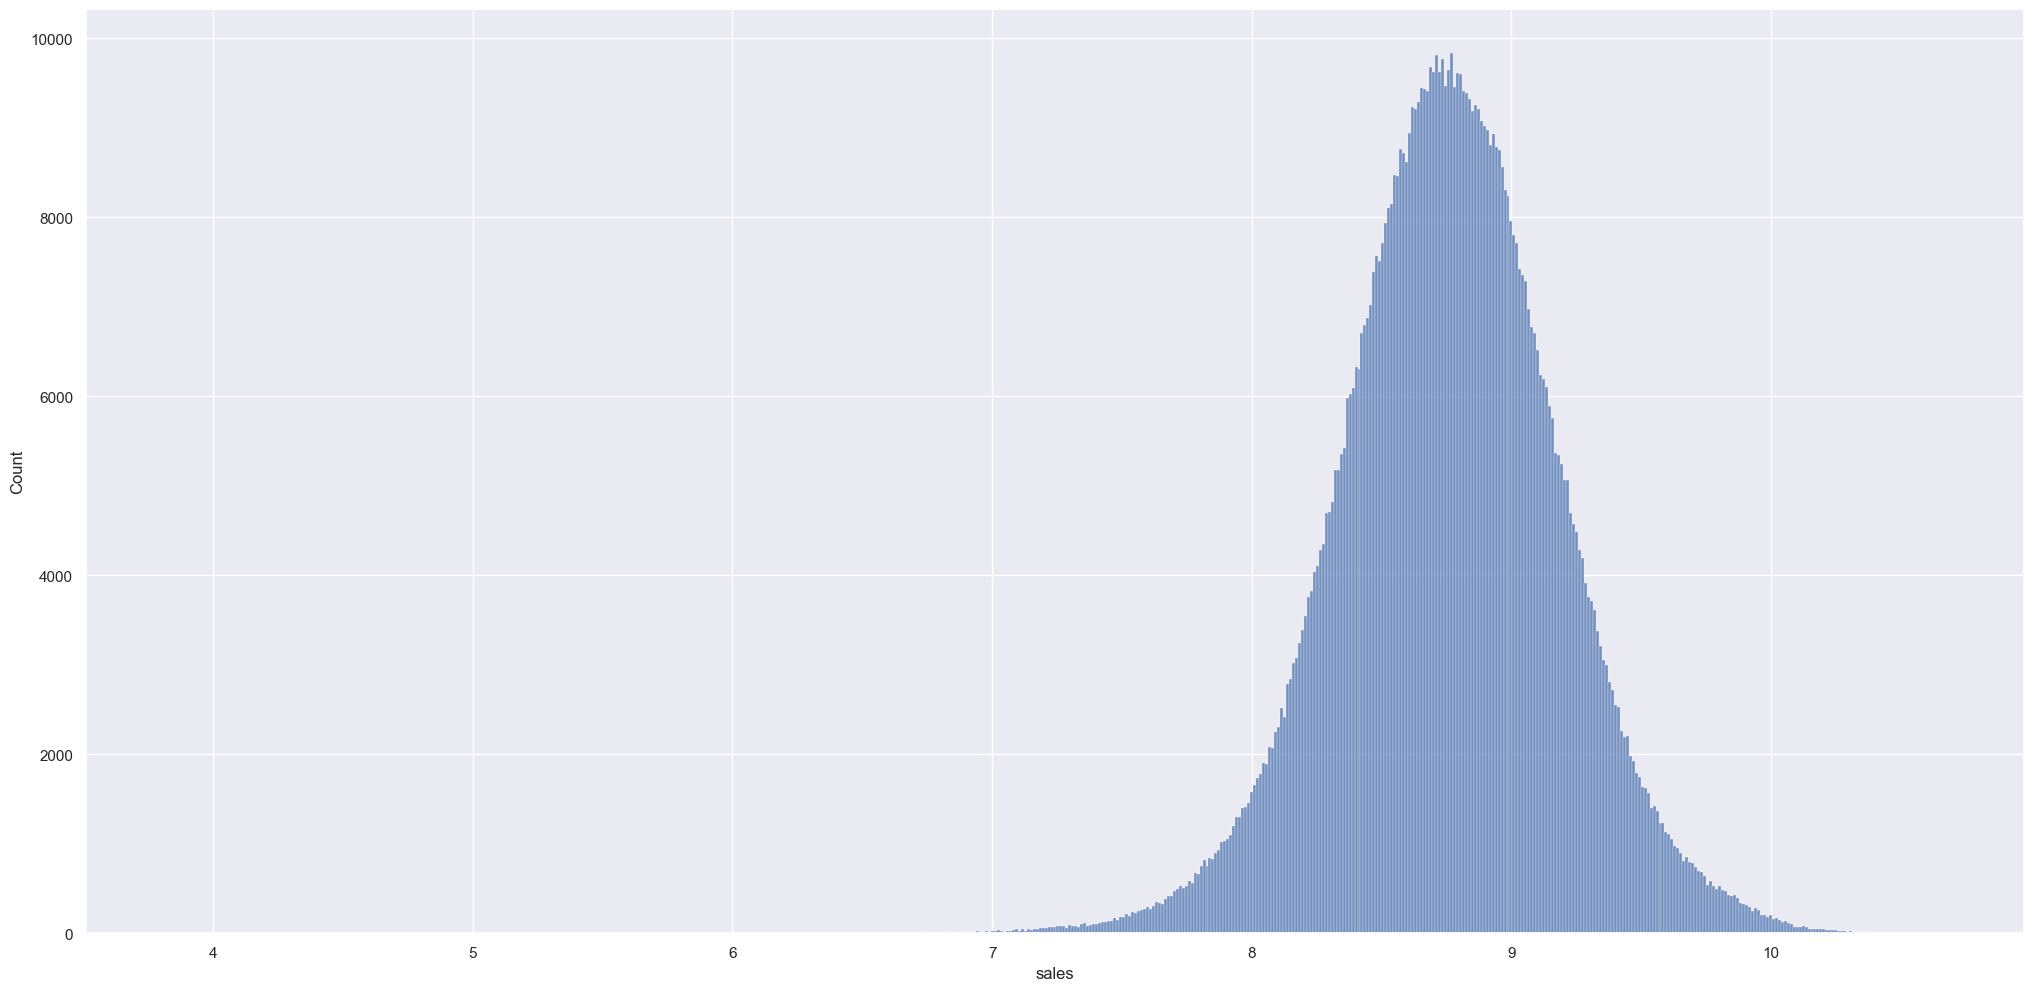

In [40]:
# Muito utilizado a transformação é a log onde realizamos a multiplicação da variável por log, modificando
# a variável resposta
sns.histplot(np.log1p(df4['sales']), kde=False);

### 4.1.2. NUMERICAL VARIABLE

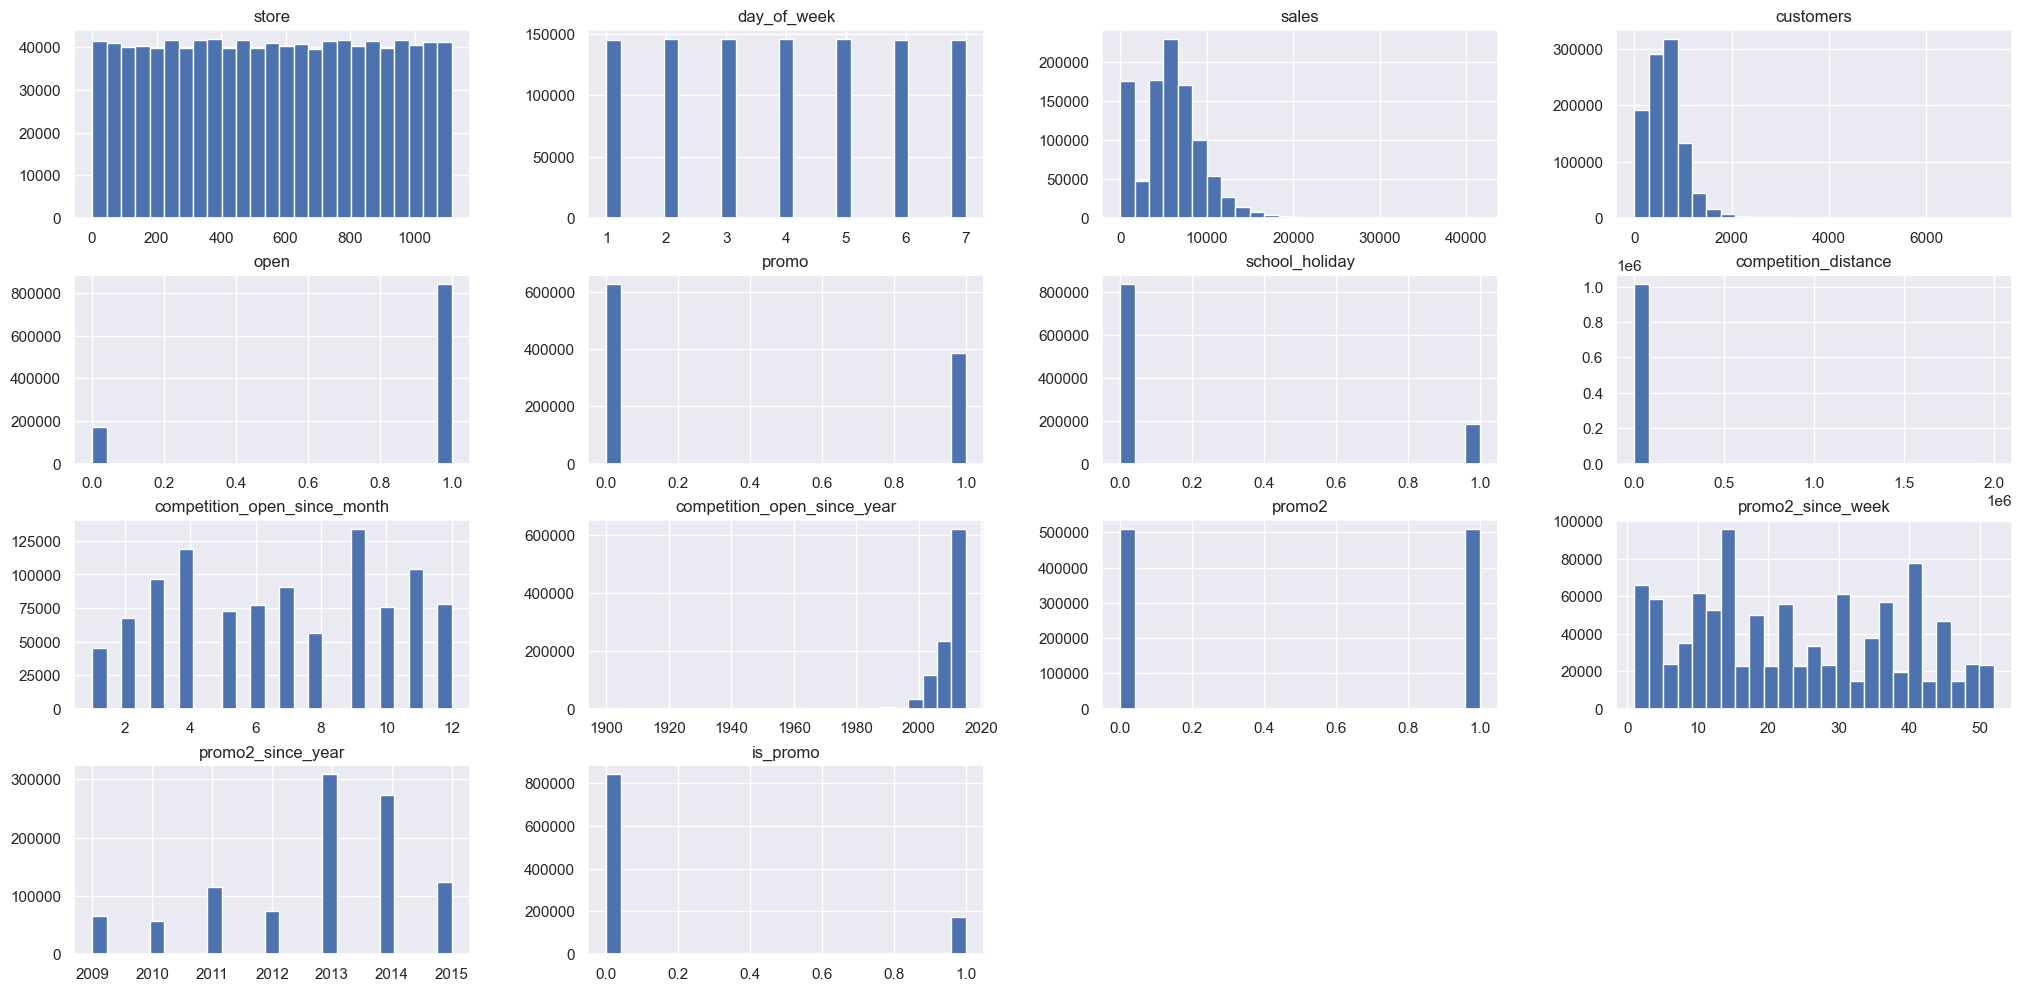

In [41]:
# Plotar histogramas das variáveis numericas
# o parametro bins é cada um dos retangulos que armarzena os dados
num_attributes.hist(bins=25);

### 4.1.3. CATEGORICAL VARIABLE

In [42]:
df4['state_holiday'].drop_duplicates().head()

0            regular_day
63559     public_holiday
129424    easter_holiday
241126         christmas
Name: state_holiday, dtype: object

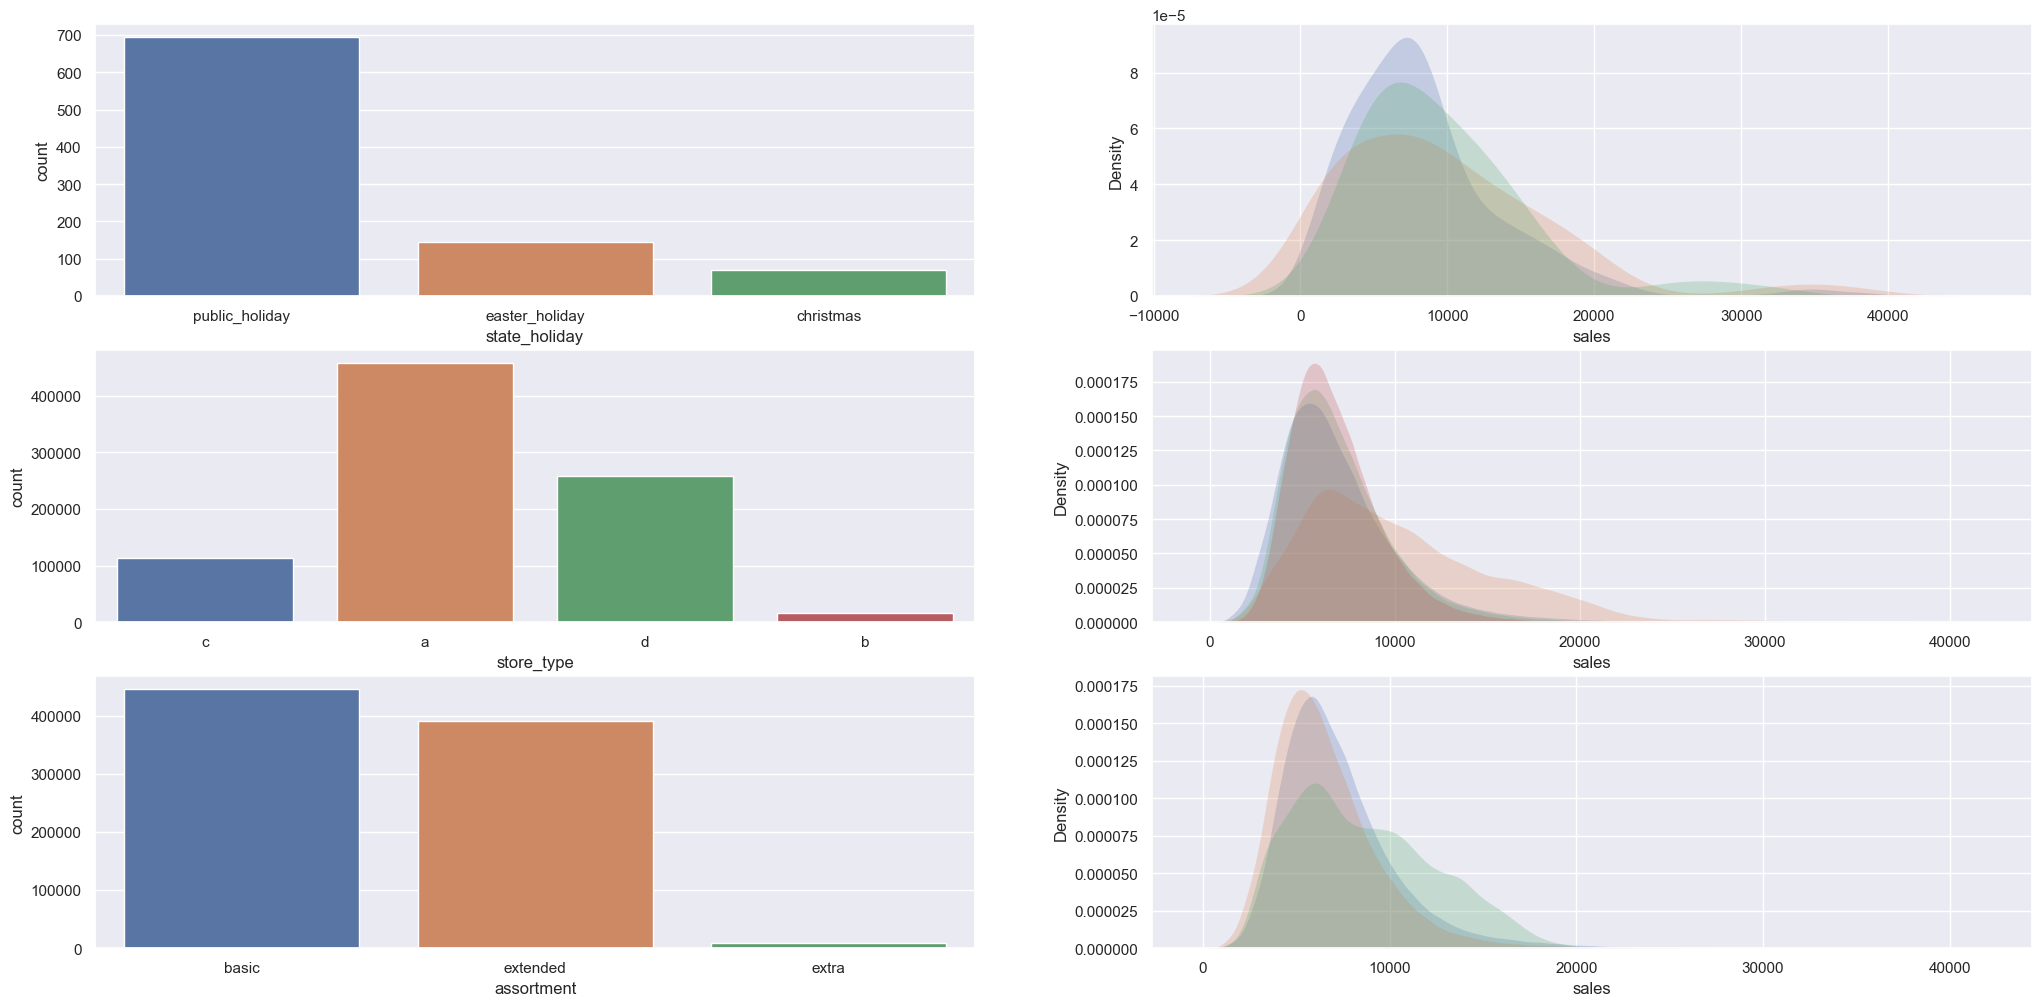

In [43]:
# state_holiday

plt.subplot(3, 2, 1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot( x=a['state_holiday'] );

plt.subplot(3, 2, 2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label = 'public_holiday', fill=True, linewidth=0);
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label = 'easter_holiday', fill=True, linewidth=0);
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label = 'christmas', fill=True, linewidth=0);

# store_type

plt.subplot(3, 2, 3)
sns.countplot( x=df4['store_type'] );

plt.subplot(3, 2, 4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label = 'a', fill=True, linewidth=0);
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label = 'b', fill=True, linewidth=0);
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label = 'c', fill=True, linewidth=0);
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label = 'd', fill=True, linewidth=0);

# assortment

plt.subplot(3, 2, 5)
sns.countplot( x=df4['assortment'] );

plt.subplot(3, 2, 6)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label = 'extended', fill=True, linewidth=0);
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label = 'basic', fill=True, linewidth=0);
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label = 'extra', fill=True, linewidth=0);


# promo_interval
# month_map

## 4.2. BIVARIATE ANALYSIS

### **H1.** Lojas com maior sortimentos deveriam vender mais.
**FALSA** Lojas com MAIOR SORTIMENTO vendam MENOS

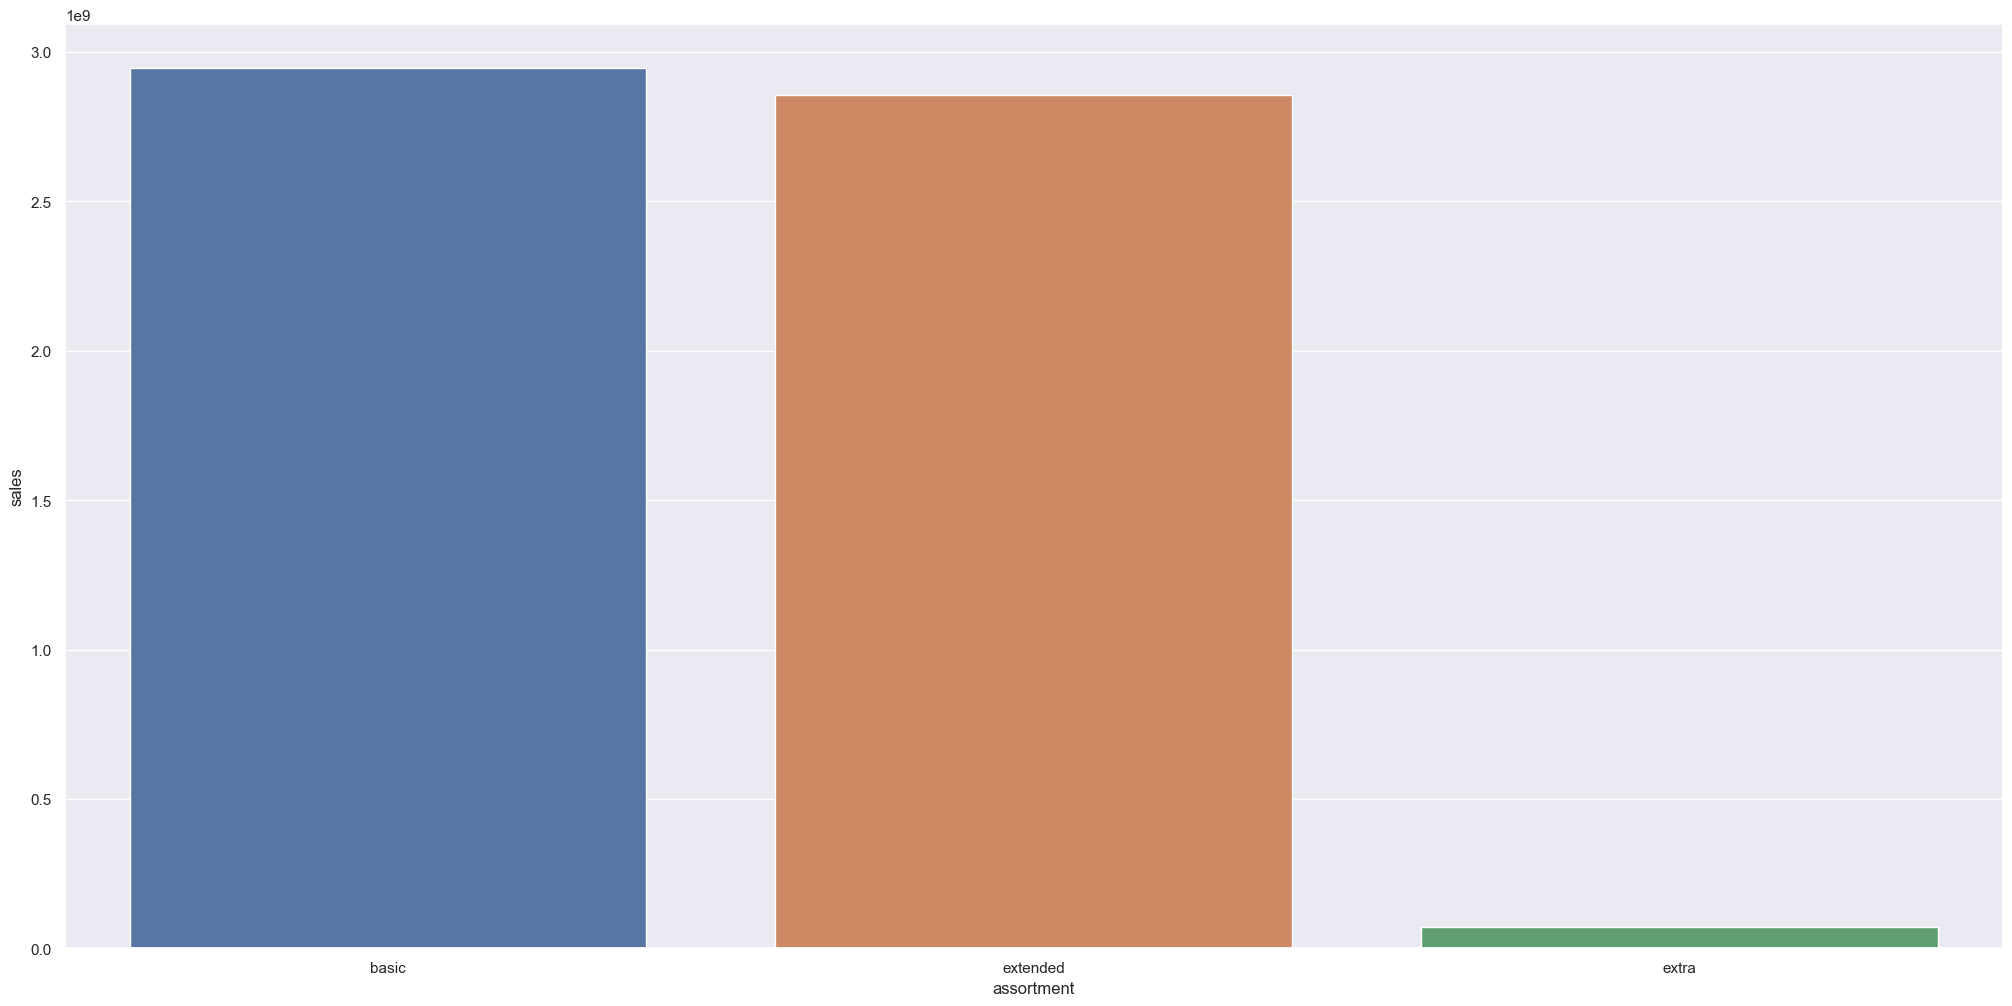

In [44]:
aux1 = df4[['assortment','sales']].groupby( 'assortment' ).sum().reset_index()
sns.barplot ( x='assortment', y='sales', data=aux1 );

# Analisando esse gráfico inicial, que o basic e o extended tem o mesmo volume de vendas e o extra tem um volume de vendas bem menor.
# Levando em consideração a primeira hipotese, lojas com assortment maior, que no conjunto de dados é o extra, tem o menor volume de vendas, com essas informações
# podemos assumir que a hipótese é falsa, pois lojas com assortment extra vendem menos.

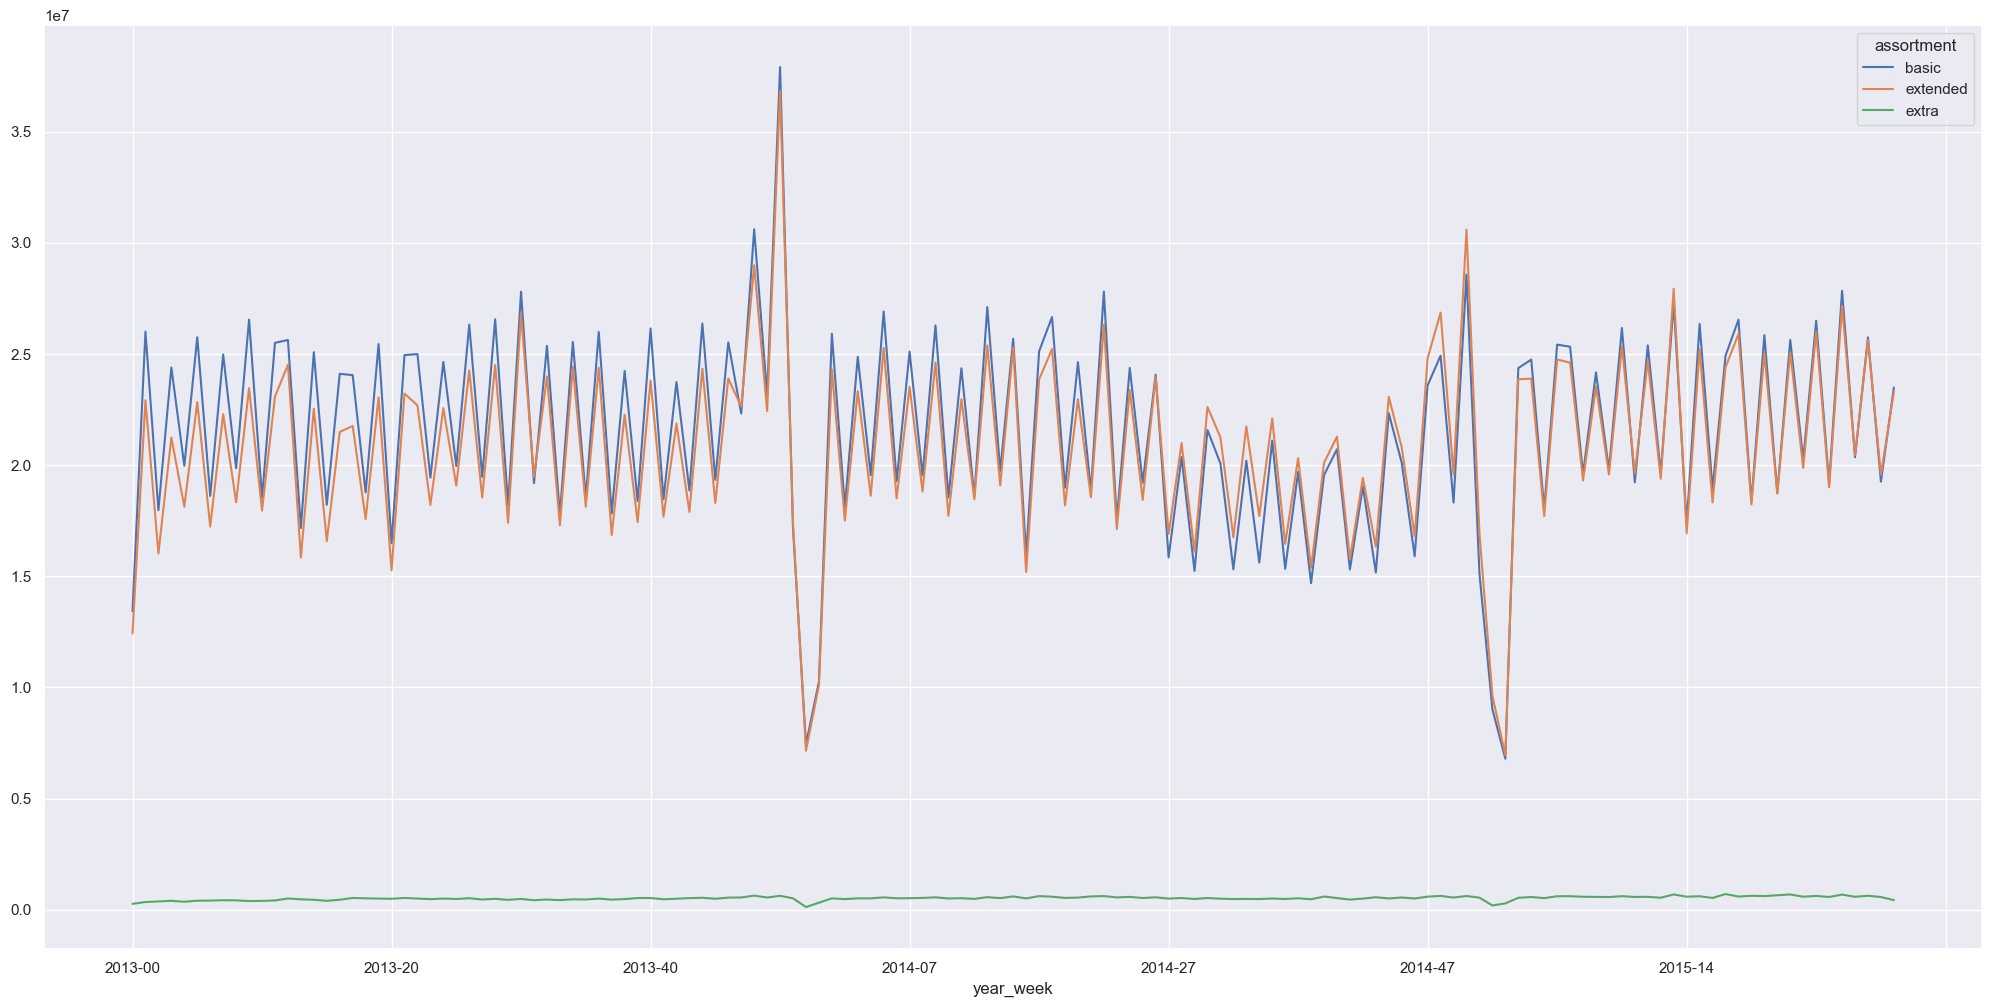

In [45]:
# Vamos analisar o comportamento ao longo do tempo? Será que ocorreu alguma mudança que levou o assortment extra a vender menos.
aux2 = df4[['year_week','assortment','sales']].groupby( ['year_week', 'assortment'] ).sum().reset_index()

# Pivot do dataframe para deixar os assortment em colunas e manter o padrão de uma linha por dia
aux2_piv = aux2.pivot ( index='year_week', columns='assortment', values='sales' ).plot()

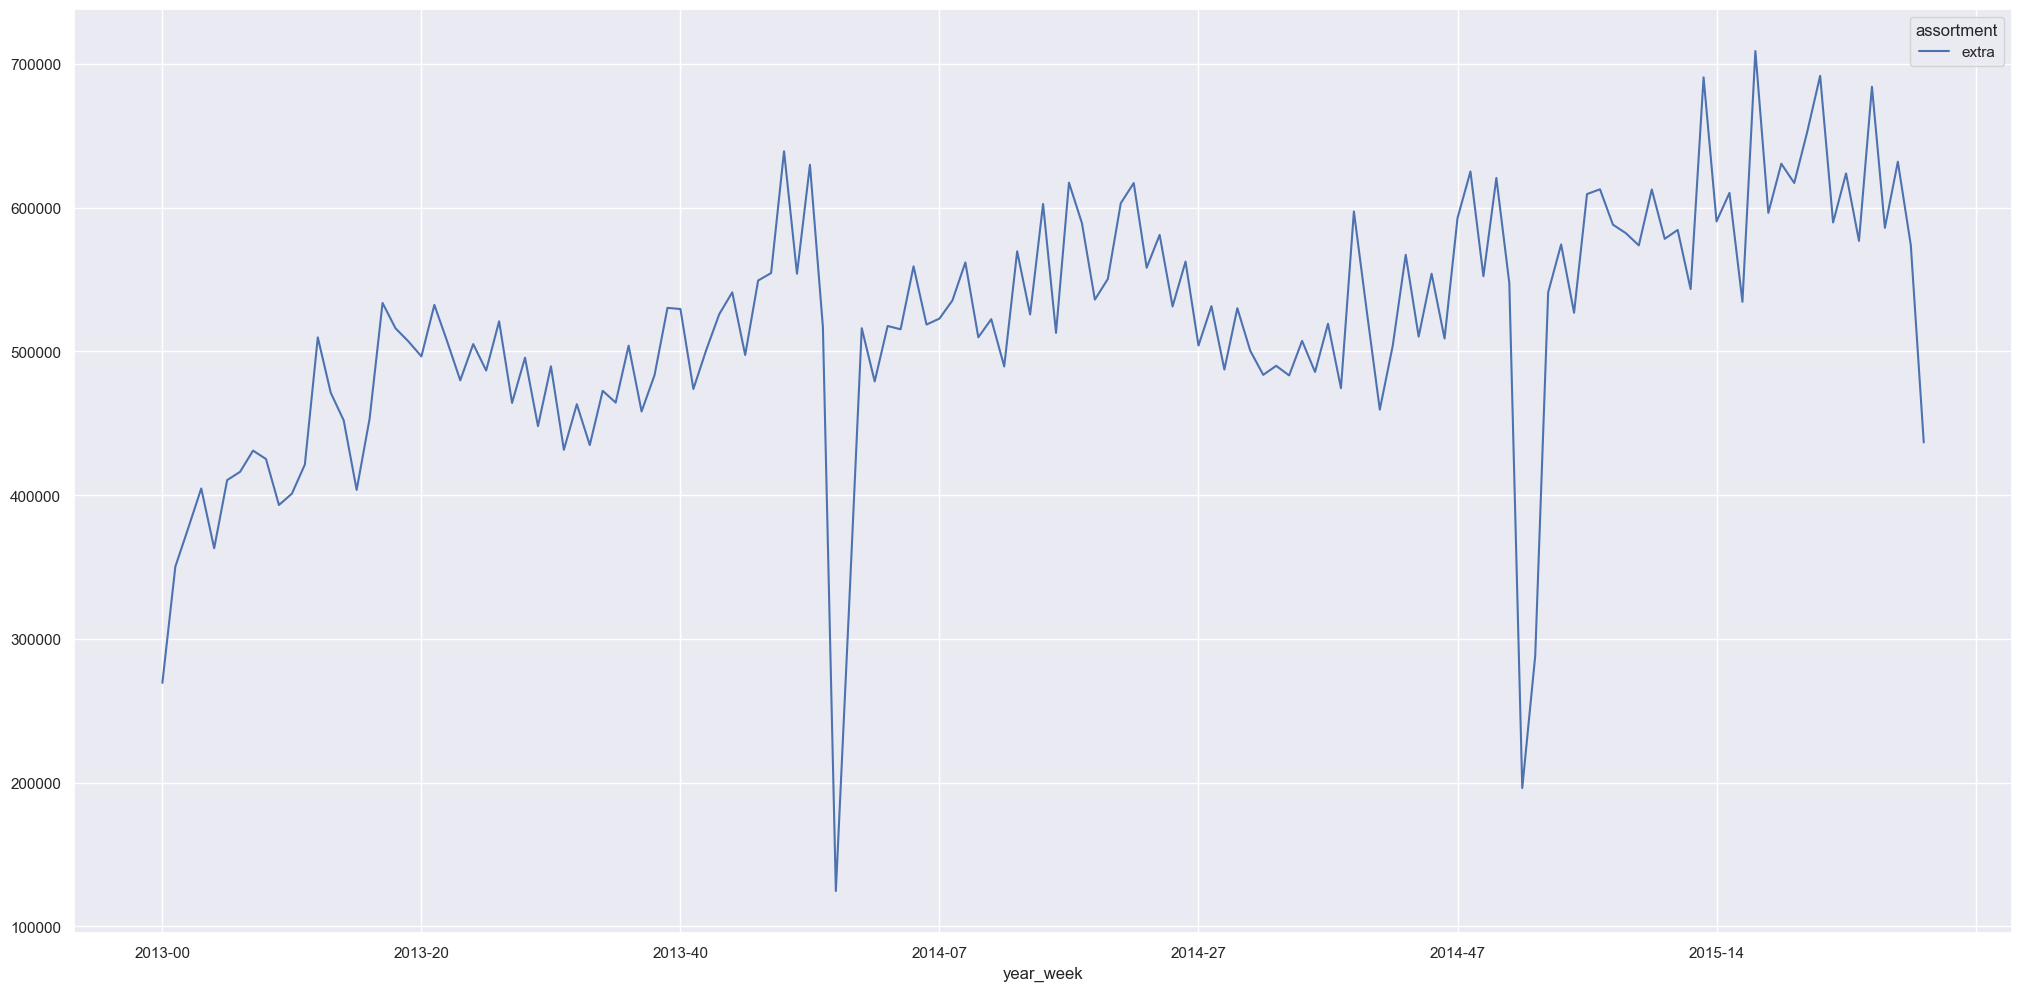

In [46]:
# Estamos observando ao analisar o gráfico que, o comportamento dos assortment basic e extended são similares, já o extra é bem menor.
# Será que a escala das vendas de basic e extended está puxando muito para cima?

# Filtrar o assortment extra e plotar o gráfico de linha
aux3 = aux2.loc[aux2['assortment'] == 'extra' ]
aux3.pivot ( index='year_week', columns='assortment', values='sales' ).plot();

# Podemos obsevaer que o comportamento não é tão linear quando aparentava ser no gráfico que o mesmo estava com os demais assortment

### **H2.** Lojas com competidores mais próximos deveriam vender menos.
**FALSA** Lojas com COMPETIDORES MAIS PRÓXIMOS vendem MAIS.

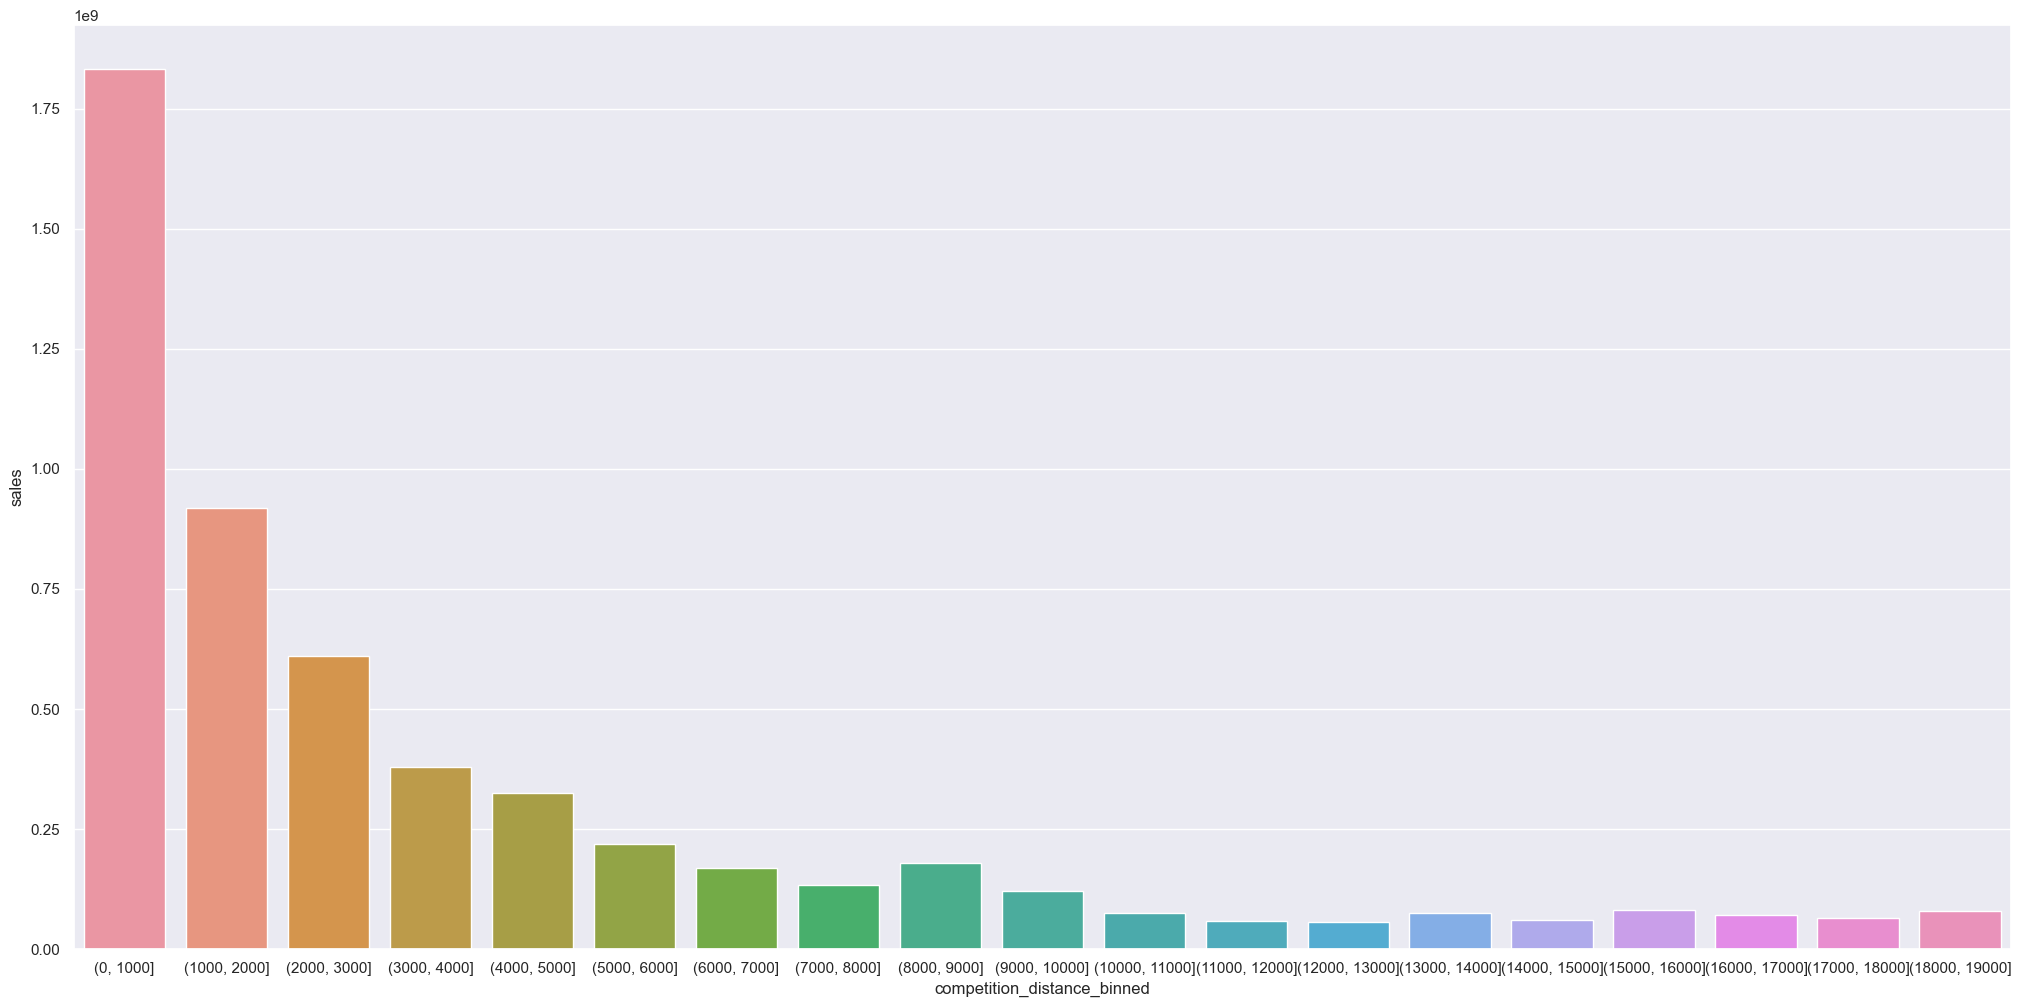

In [47]:
# Agrupar dados para análise
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

# Vamos melhorar a visualização, devido a variedade de distâncias existente no dataframe

# Criando uma variável bins que recebe uma lista com números que irão de 0 a 20000 e serão criados de 1000 em 1000
# Essa decisão é arbitraria
bins = list(np.arange(0, 20000, 1000))

# Criar uma coluna com os respectivos grupos, usando o método cut para fazer essa verificação em cada uma dos valores de competition_distance.
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins = bins)

# Criar variável com os dados filtrados, considerando essa nova coluna competition_distance_binned
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()

# Plotar o gráfico para analisar
sns.barplot(x = 'competition_distance_binned' , y = 'sales', data = aux2);


Obs: Na legenda: () não inclui o intervalo, e [] inclui o intervalo. Ex: (0, 1500] é do 1 ao 1500.

No senso comum, lojas com competidores, que segue essa hipótese, lojas com competidores mais próximos deveriam vender menos, por ter um maior compartilhamento de clientes.

Os resultados iniciais mostram que lojas com competidores mais proximos vendem mais, podemos considerar esse um excelente insight **quanto MENOR a DISTÂNCIA dos competidores, MAIOR a QUANTIDADE DE VENDAS**.

Vamos aprofundar a análise para avaliar se essa variável pode ser relevante para o modelo.

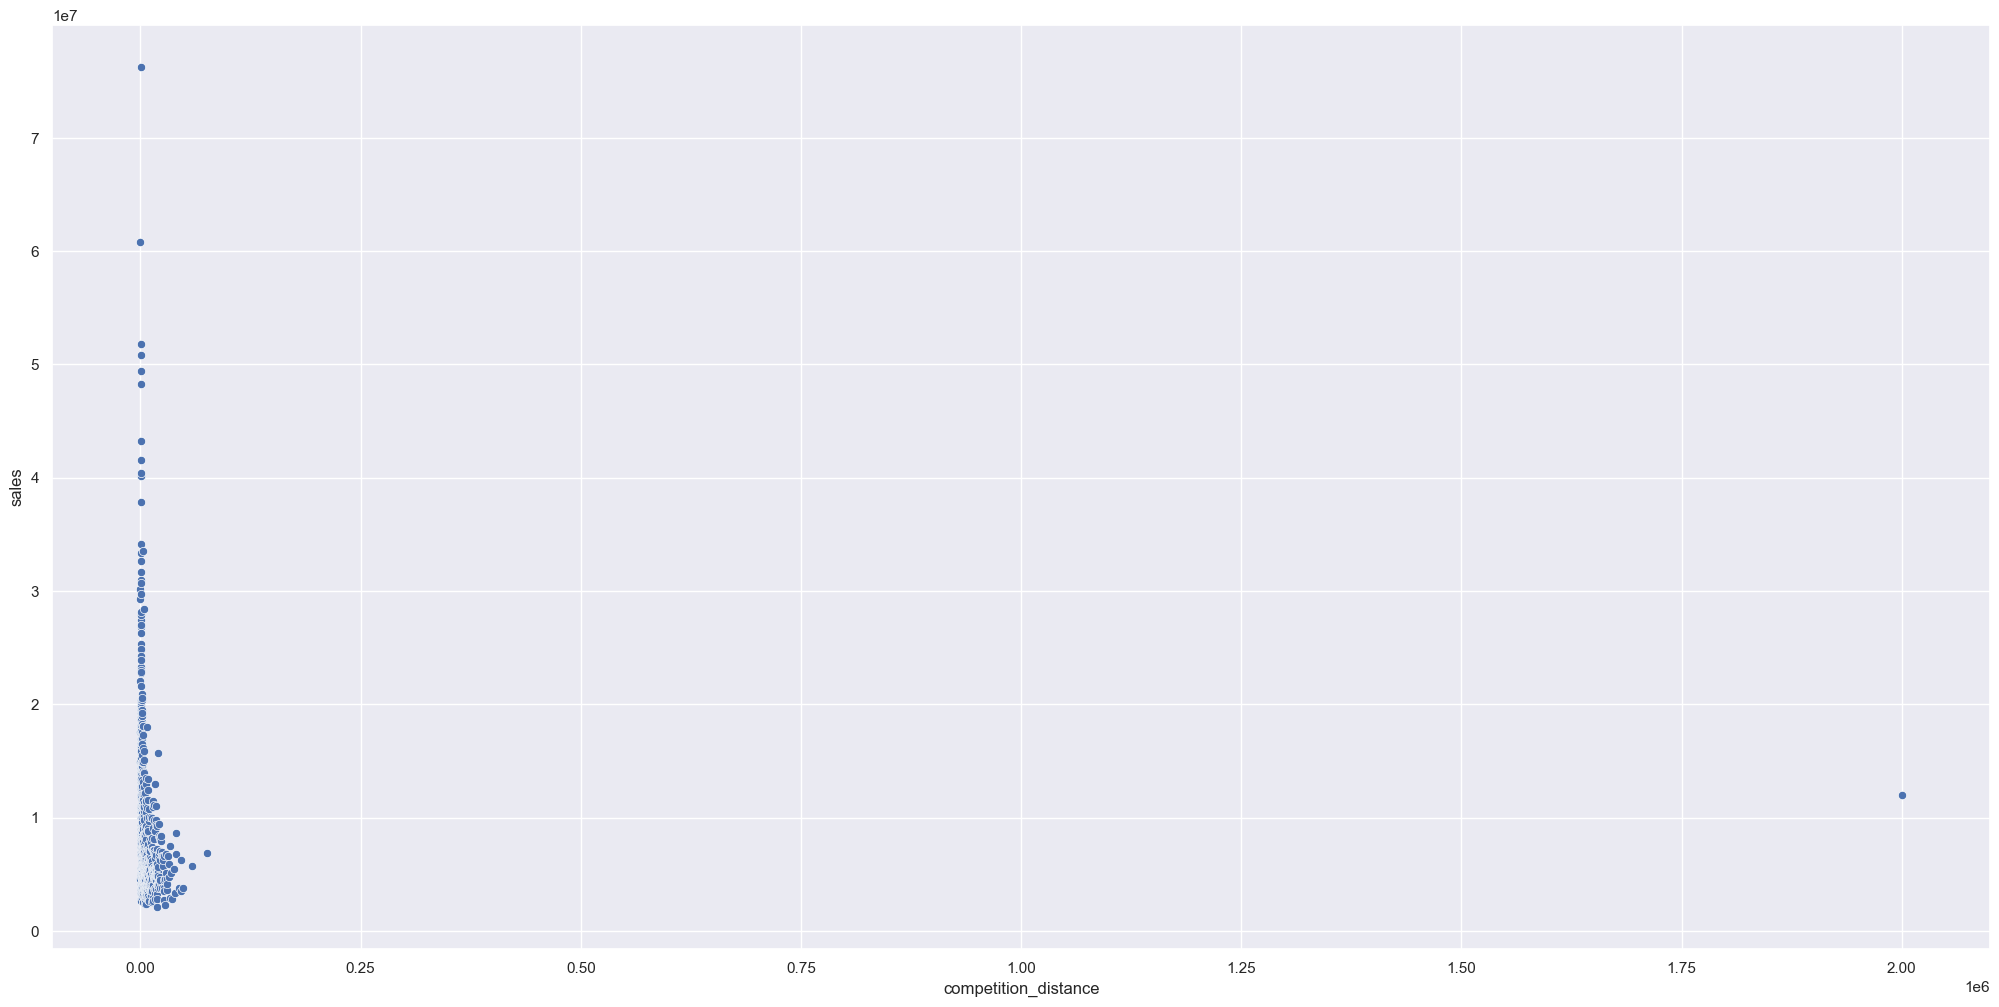

In [48]:
# Como temos dados muito uma granulares, vamos usar o scatter plot avaliar a distribuição
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()
sns.scatterplot(x = 'competition_distance', y = 'sales', data = aux1);

Iremos nos aprofundar nessa análise, avaliando a força de correlação entre as variáveis 'competition_distance' e 'sales', para entender a força do impacto dessa variável na variável resposta.

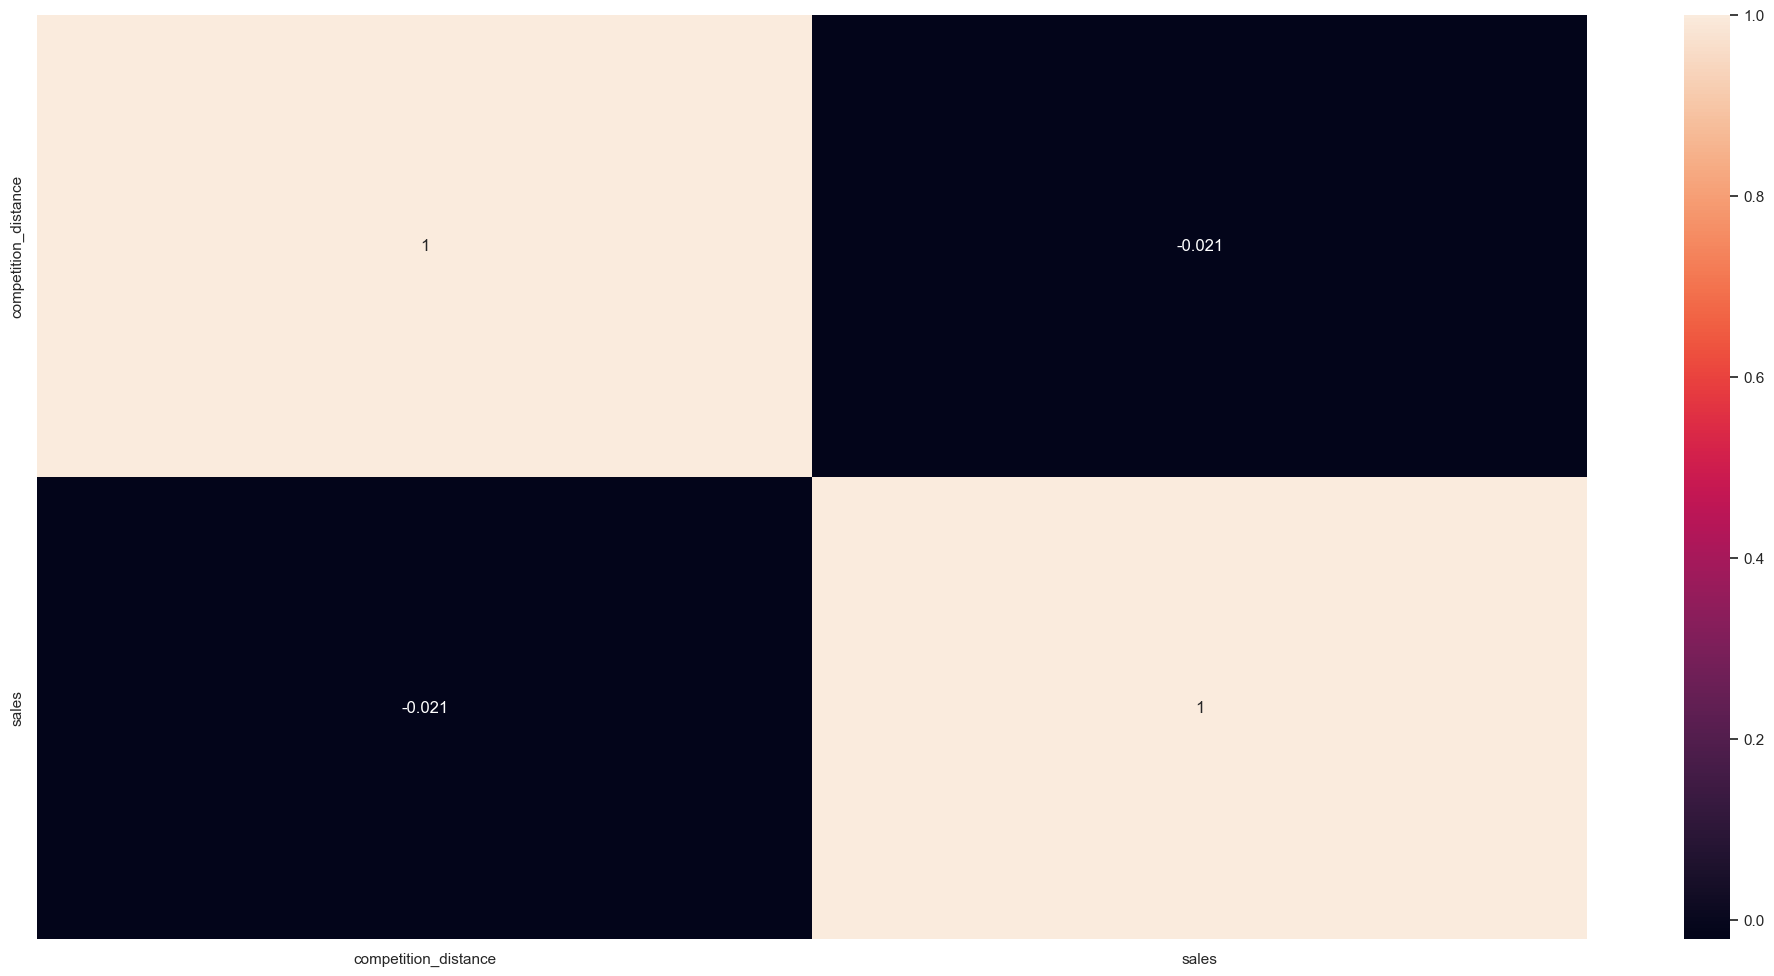

In [49]:
sns.heatmap(aux1.corr(method='pearson'), annot = True);

Há correlação mas é fraca: Conforme aumenta a distância, diminue as vendas.

Como a correlação é fraca, assumimos que o fenômeno (venda), aumenta ou diminui muito mais por interfefência de outros agentes (a ser estudados) do que pela distância da concorrência isolada.

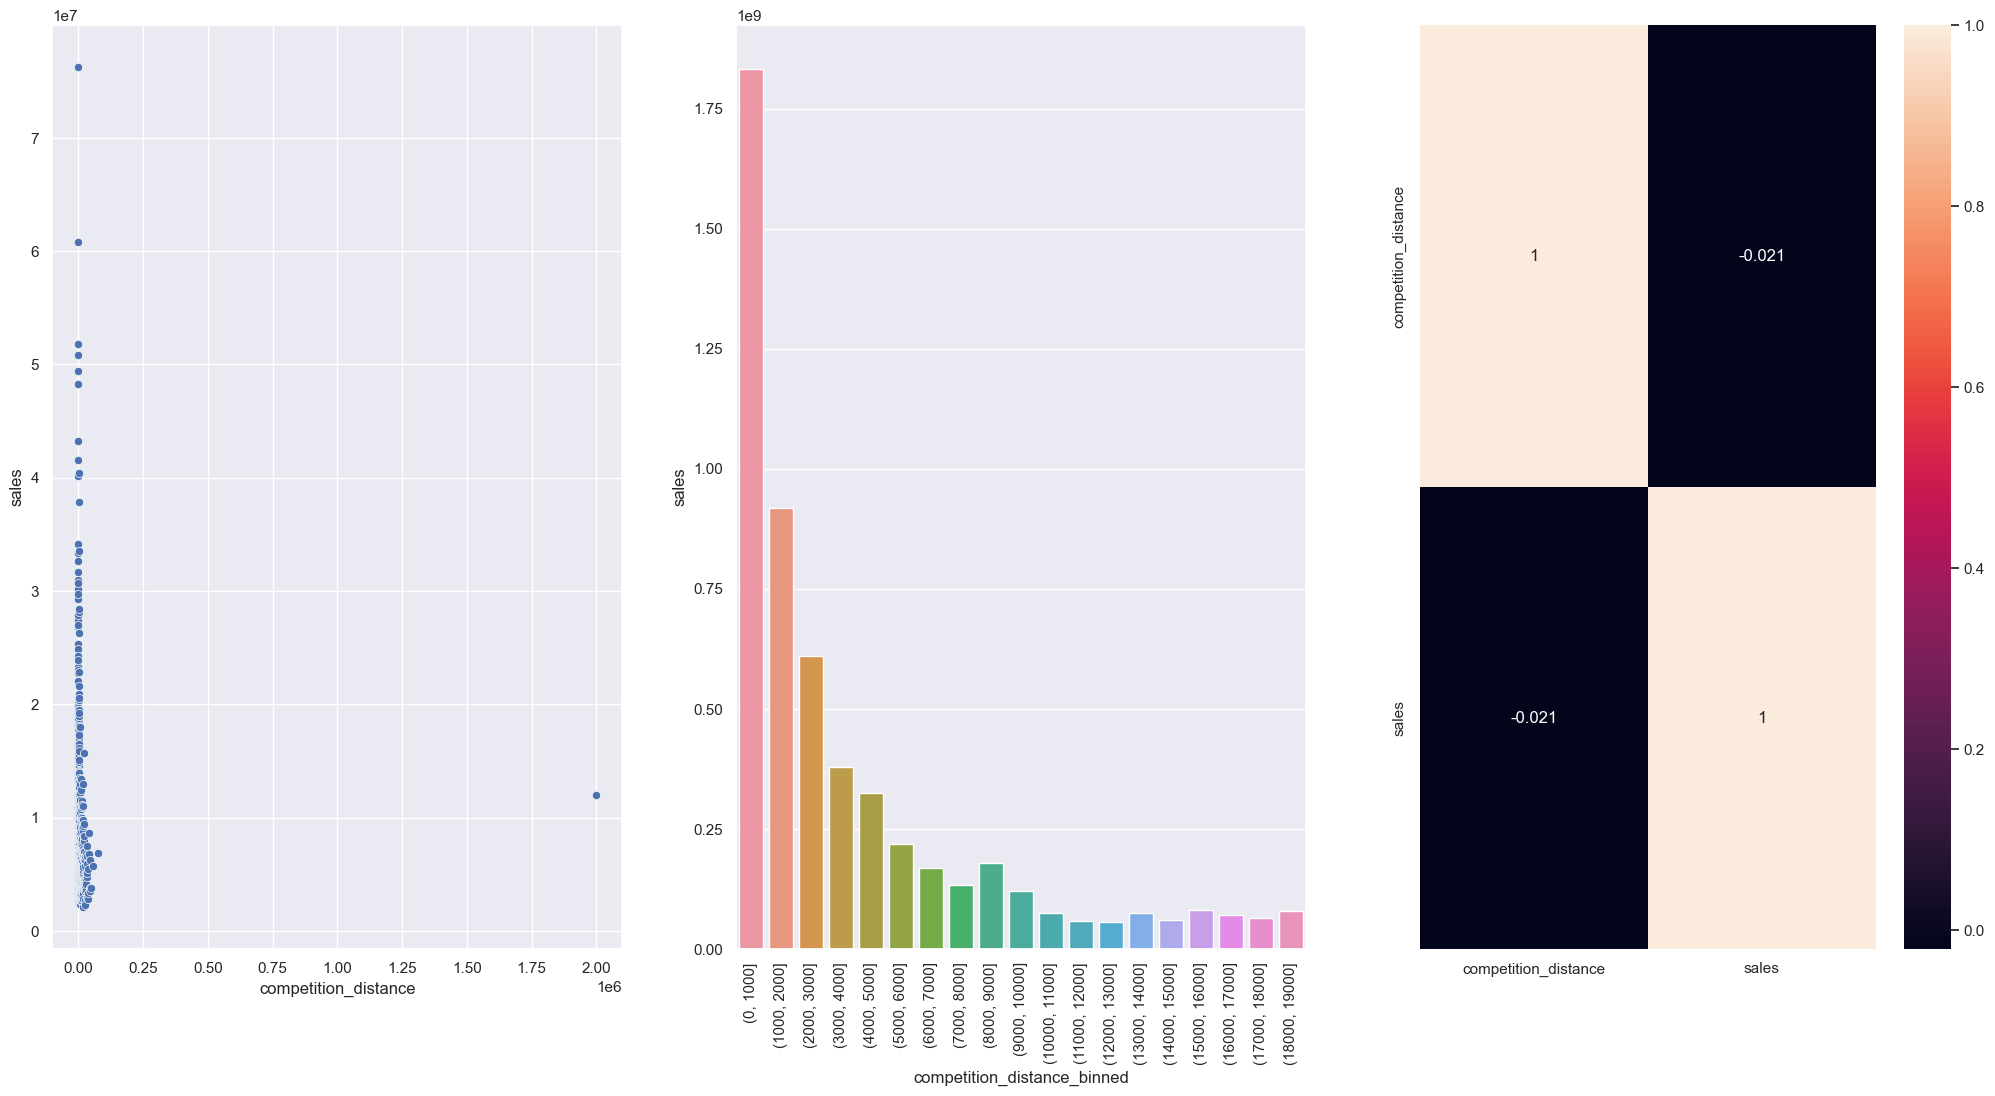

In [50]:
# Agrupar todas as análise

aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

plt.subplot(1, 3, 1)
sns.scatterplot(x = 'competition_distance', y = 'sales', data = aux1);

plt.subplot(1, 3, 2)
bins = list(np.arange(0, 20000, 1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins = bins)
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(x = 'competition_distance_binned' , y = 'sales', data = aux2);
plt.xticks(rotation=90);

plt.subplot(1, 3, 3)
aux3 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()
sns.heatmap(aux3.corr(method='pearson'), annot=True);

### **H3.** Lojas com competidores à mais tempo deveriam vendem mais.
**FALSA** Loja com COMPETIDORES À MAIS TEMPO vedem MENOS

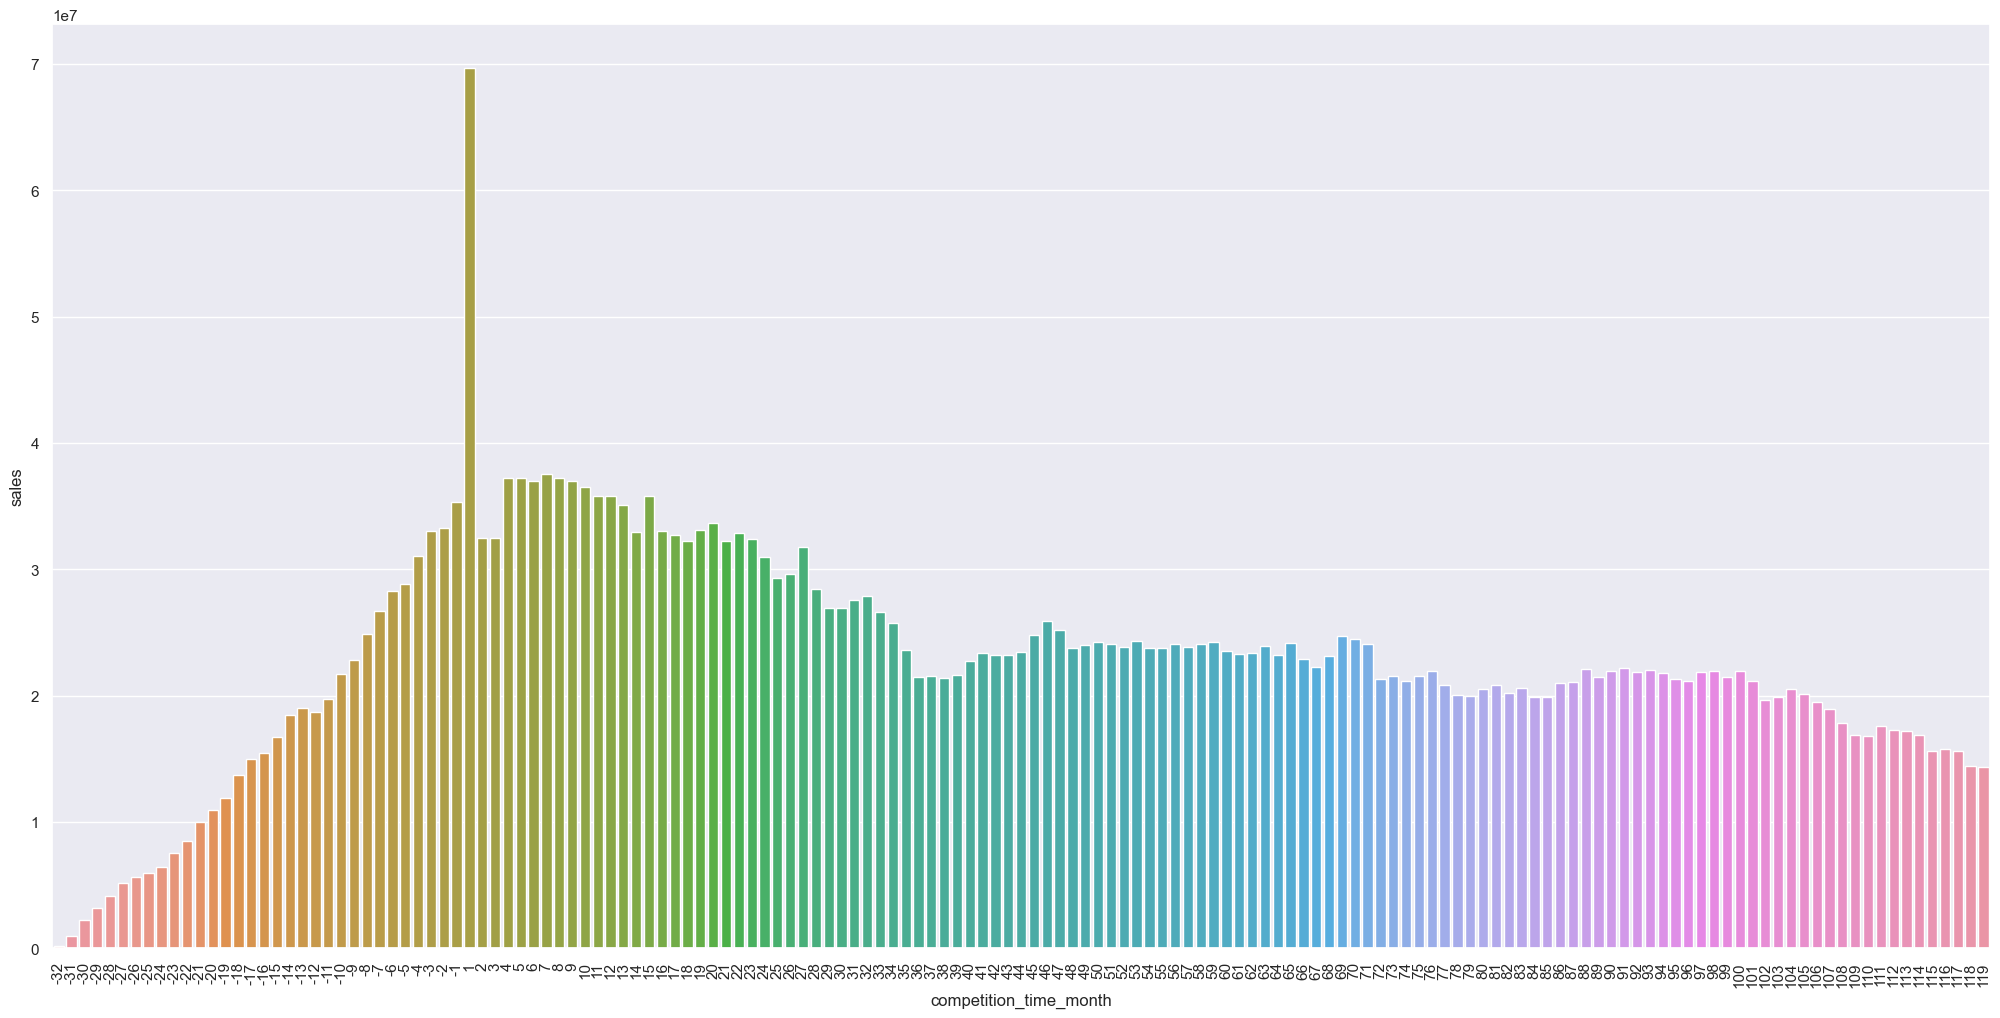

In [51]:
# Qual a relação que existe entre o tempo que o competidor está aberto e as vendas

# Vamos usar a variável que derivamos anteriormente 'competition_time_month' para ver há quantos meses existe competição
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
# Realizar um filtro para melhor visualização dos dados:
# - Competidores nos primeiros 120 meses;
# - Competidores que abriram em mês diferente do mesmo da venda, (esses valores foram assumidos para tratar ausência de informação em etapas anteriores)
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0 )]
# Plotar o gráfico
sns.barplot(x = 'competition_time_month' , y = 'sales' , data = aux2);
plt.xticks(rotation =90);

Essa variável 'competition_time_month' foi derivada consideramos a diferença da data da venda com a data de abertura do competidor.

- Se a data da venda for maior, vamos ter valores positivos
- Se a data da venda for menor que a data de abertura do competidor (data da venda é a data atual e o competidor vai abrir daqui á alguns meses), os valores serão negativos.

Quanto mais se aproxima de zero, maior é a quantidade de vendas, quanto mais recente é a competição, maior a venda. Bem contraditorio ao senso comum.

Vamos tentar avaliar através de um gráfico olhando a existência de tendência

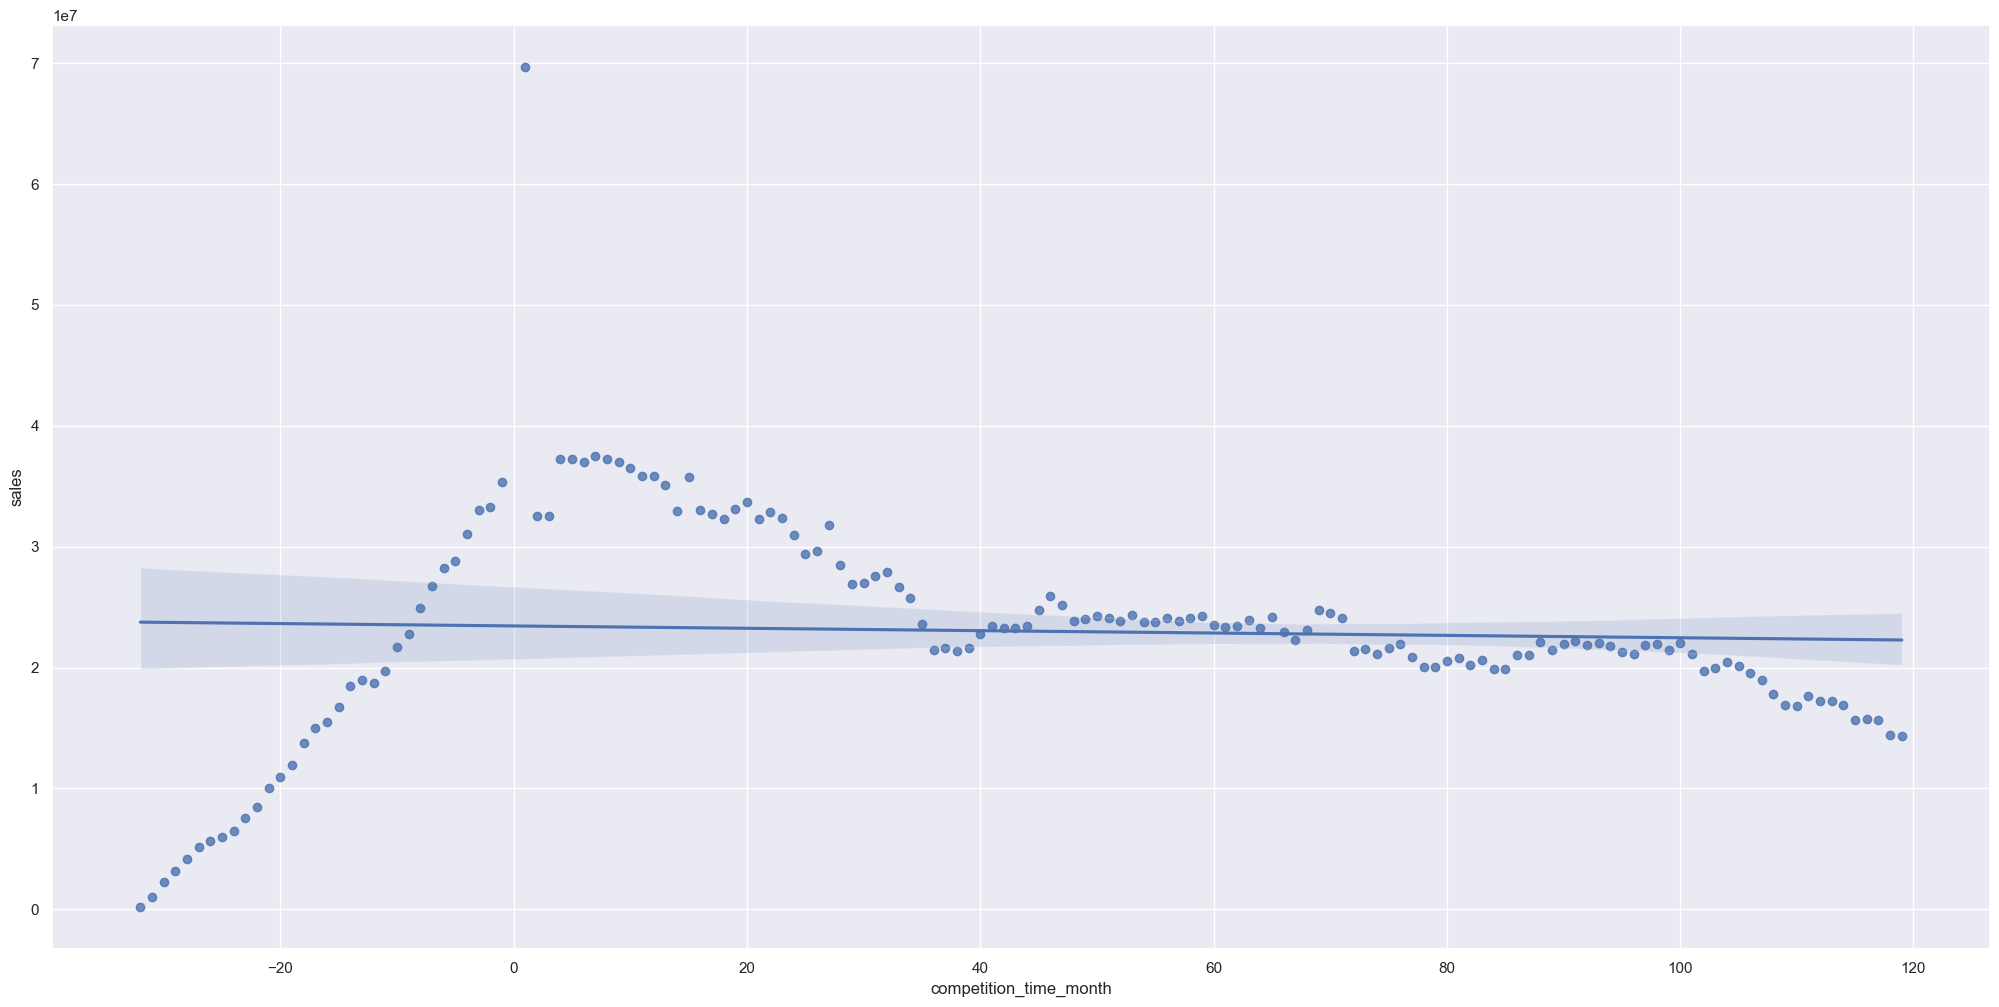

In [52]:
sns.regplot(x = 'competition_time_month', y = 'sales', data = aux2);

Apesar de apresentar uma linha de tendência em queda, não podemos nos focar muito nisso, devido comportamento não ser linear, não podemos nos basear nisso.

Nós temos um comportamento de crescimento e decaimento, se traçar uma linha de tendência linear, estamos enviesado ao erro.

Vamos avaliar o correlação entre as variáveis.

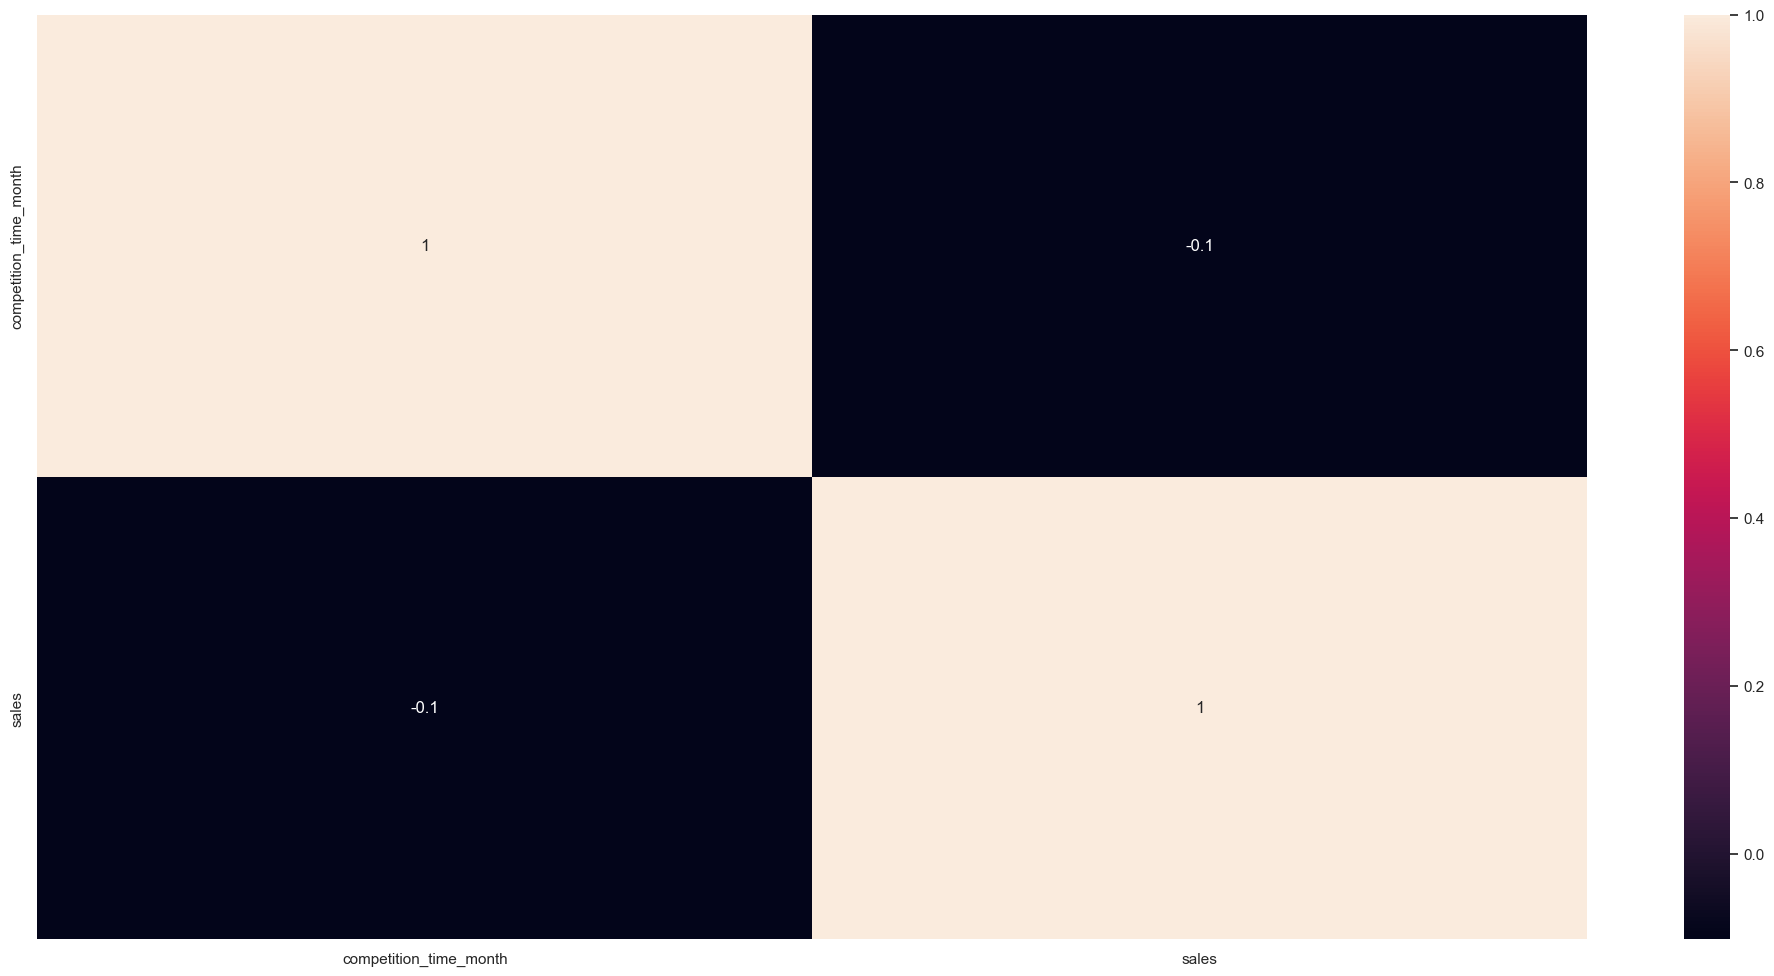

In [53]:
sns.heatmap(aux1.corr(method= 'pearson'), annot = True);

Correlação entre 'competition_time_month' e a variável resposta é de -0.1, pode ser considerada uma correlação interessante, não sendo extremamente baixa. mas está longe de 1 e -1.

Será uma variável relevante para o modelo.

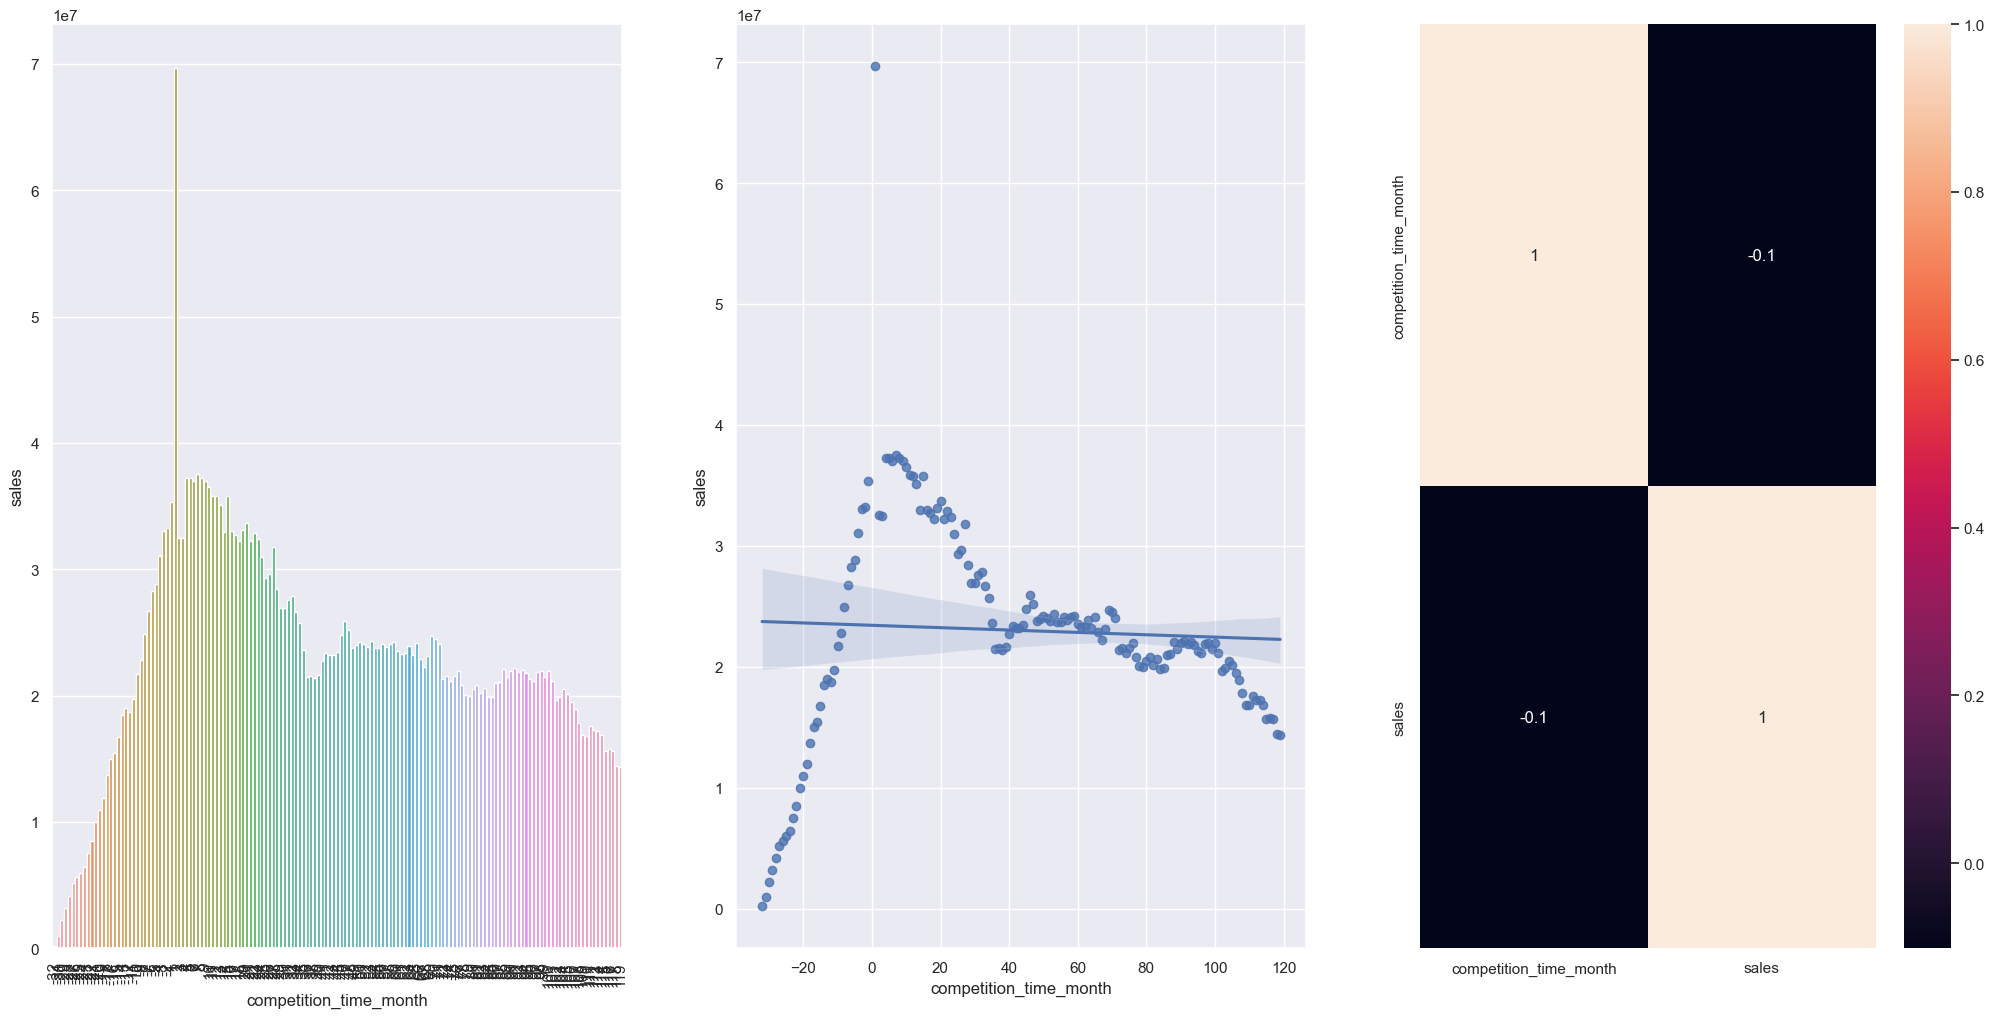

In [54]:
plt.subplot(1, 3, 1)
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0 )]
sns.barplot(x = 'competition_time_month' , y = 'sales' , data = aux2);
plt.xticks(rotation = 90);

plt.subplot(1, 3, 2)
sns.regplot(x = 'competition_time_month', y = 'sales', data = aux2);

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method= 'pearson'), annot = True);

### **H4.** Lojas com promoções ativas por mais tempo deveriam vender mais.
**FALSA**  Lojas com promoções ativas por mais tempo vendem menos, depois de um certo período de promoção

In [56]:
# Visualizar as primeiras linhas do dataframe
df4.head()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


Relembrando o entendimento da variável **'promo_time_week'**:
 - a variável **'promo_time_week'** nos diz quanto tempo faz que a promoção está ativa.

Como ela foi derivada?
 - A Rossmann possui uma promoção extra, que algumas lojas entram apoós o termino do período de promoção. Essa estratégia não é adotada por todas as lojas, dessa forma, no dataframe essa variável está identificada como **'promo2'**.
 - Em todas as vendas que havia ativado a promoção estendida, as variáveis **'promo2_since_week'** e a **'promo2_since_year'**, apresentavam as informações de quando a promoção estendida começou.
 - Foi calculado a diferença da data da venda com a data que a promo2 foi ativada, originando assim a variável **'promo_time_week'**

Entendimento dos resultados da variável.
 - **'promo_time_week' negativo - A compra foi feita no período da promoção tradicional** - Toda venda que foi realizada fora do período da promoção estendida, possui uma data da venda menor que a data da promoção estendida.
 - **'promo_time_week' positivo - A compra foi feita no período da promoção estendida** - Toda venda que foi realizada dentro do período da promoção estendida, possui uma data da venda maior que a data da promoção estendida. 

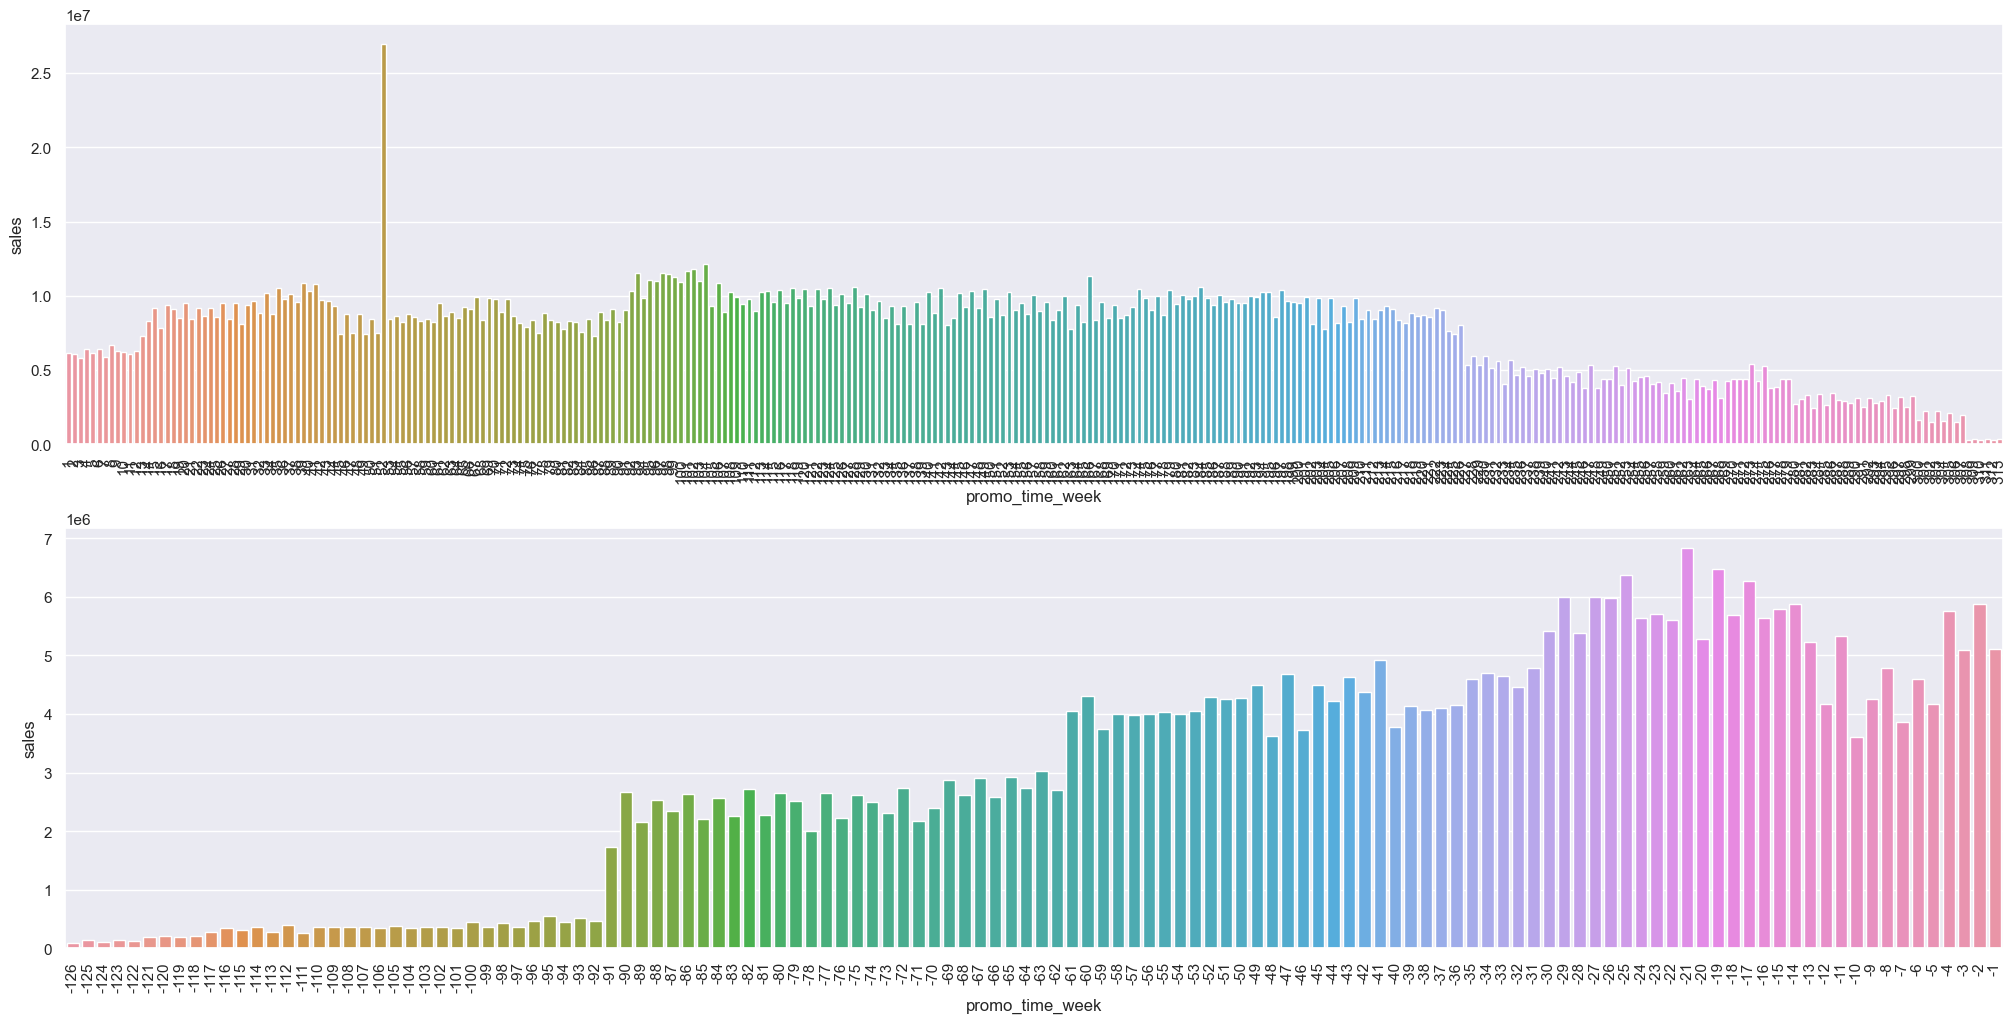

In [57]:
# Selecionar os dados para análise
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()

plt.subplot(2, 1, 1)
# Promoção Estendida
aux2 = aux1[aux1['promo_time_week'] > 0 ]
sns.barplot(x = 'promo_time_week' , y = 'sales' , data = aux2);
plt.xticks(rotation = 90);

plt.subplot(2, 1, 2)
# Promoção Tradicional
aux3 = aux1[aux1['promo_time_week'] < 0 ]
sns.barplot(x = 'promo_time_week' , y = 'sales' , data = aux3 );
plt.xticks(rotation = 90);

Inicialmente podemos observar que após um determinado período de ativação da promoção estendida, as vendas não são tão expressiva, perdenfo força ao longo do tempo.

No caso da promoção tradicional, podemos ver um aumento das vendas ao se aproximar do período da promoção.


Observando esses resultados iniciais e confrontando com a hipótese que dizia que, **"Lojas com promoções ativas por mais tempo deveriam vender mais"**, podemos considerar essa hipótese como falsa. Ela vende regularmente até determinado tempo, após determinado tempo as vendas possui um decaimento.

Os dados possui um comportamento visível, seguimos avaliando se realmente possui tendência.

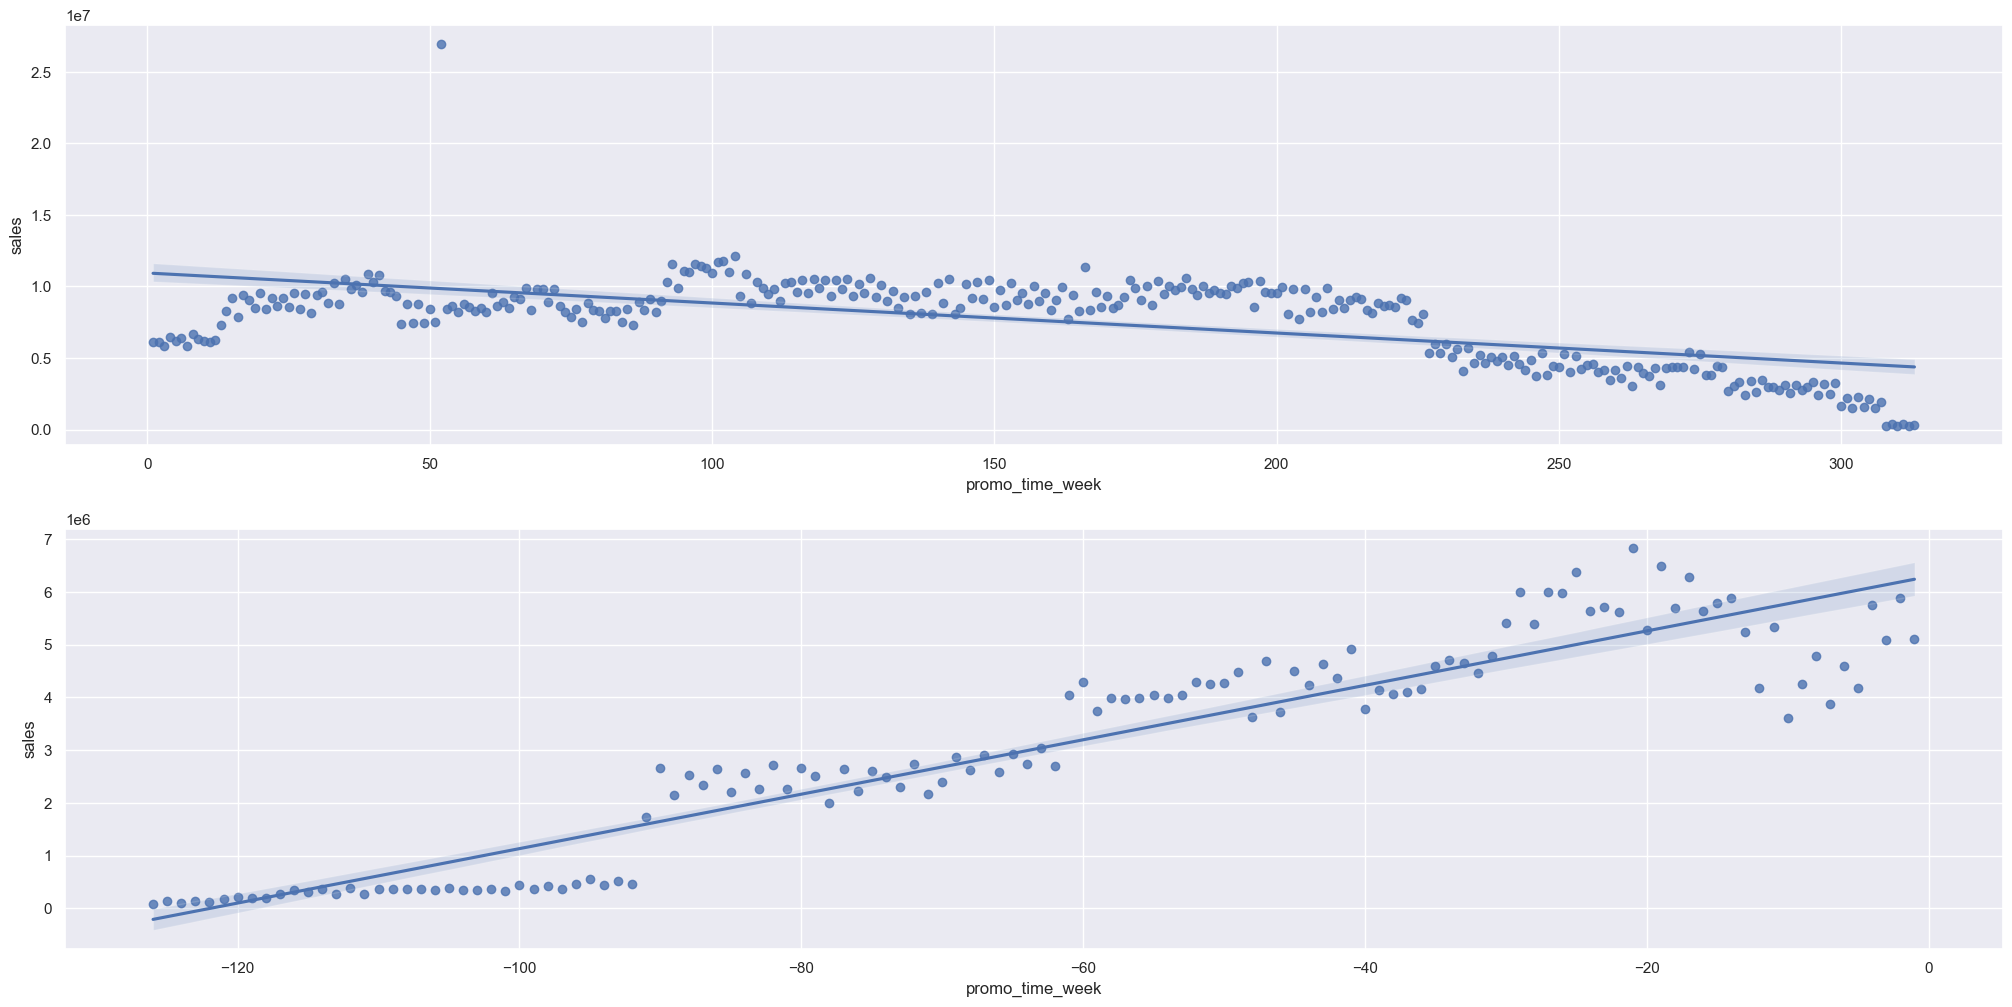

In [60]:
# Analisar a tendência dos dados

plt.subplot(2, 1, 1)
# Promoção Estendida
aux2 = aux1[aux1['promo_time_week'] > 0 ]
sns.regplot(x = 'promo_time_week' , y = 'sales' , data = aux2);

plt.subplot(2, 1, 2)
# Promoção Tradicional
aux3 = aux1[aux1['promo_time_week'] < 0 ]
sns.regplot(x = 'promo_time_week' , y = 'sales' , data = aux3 );

Após essa visualização fica claro a existência de tendência

Seguir com a análise da exitencia de correlação entre a variável **'promo_time_week'** com a variável resposta **'sales'**

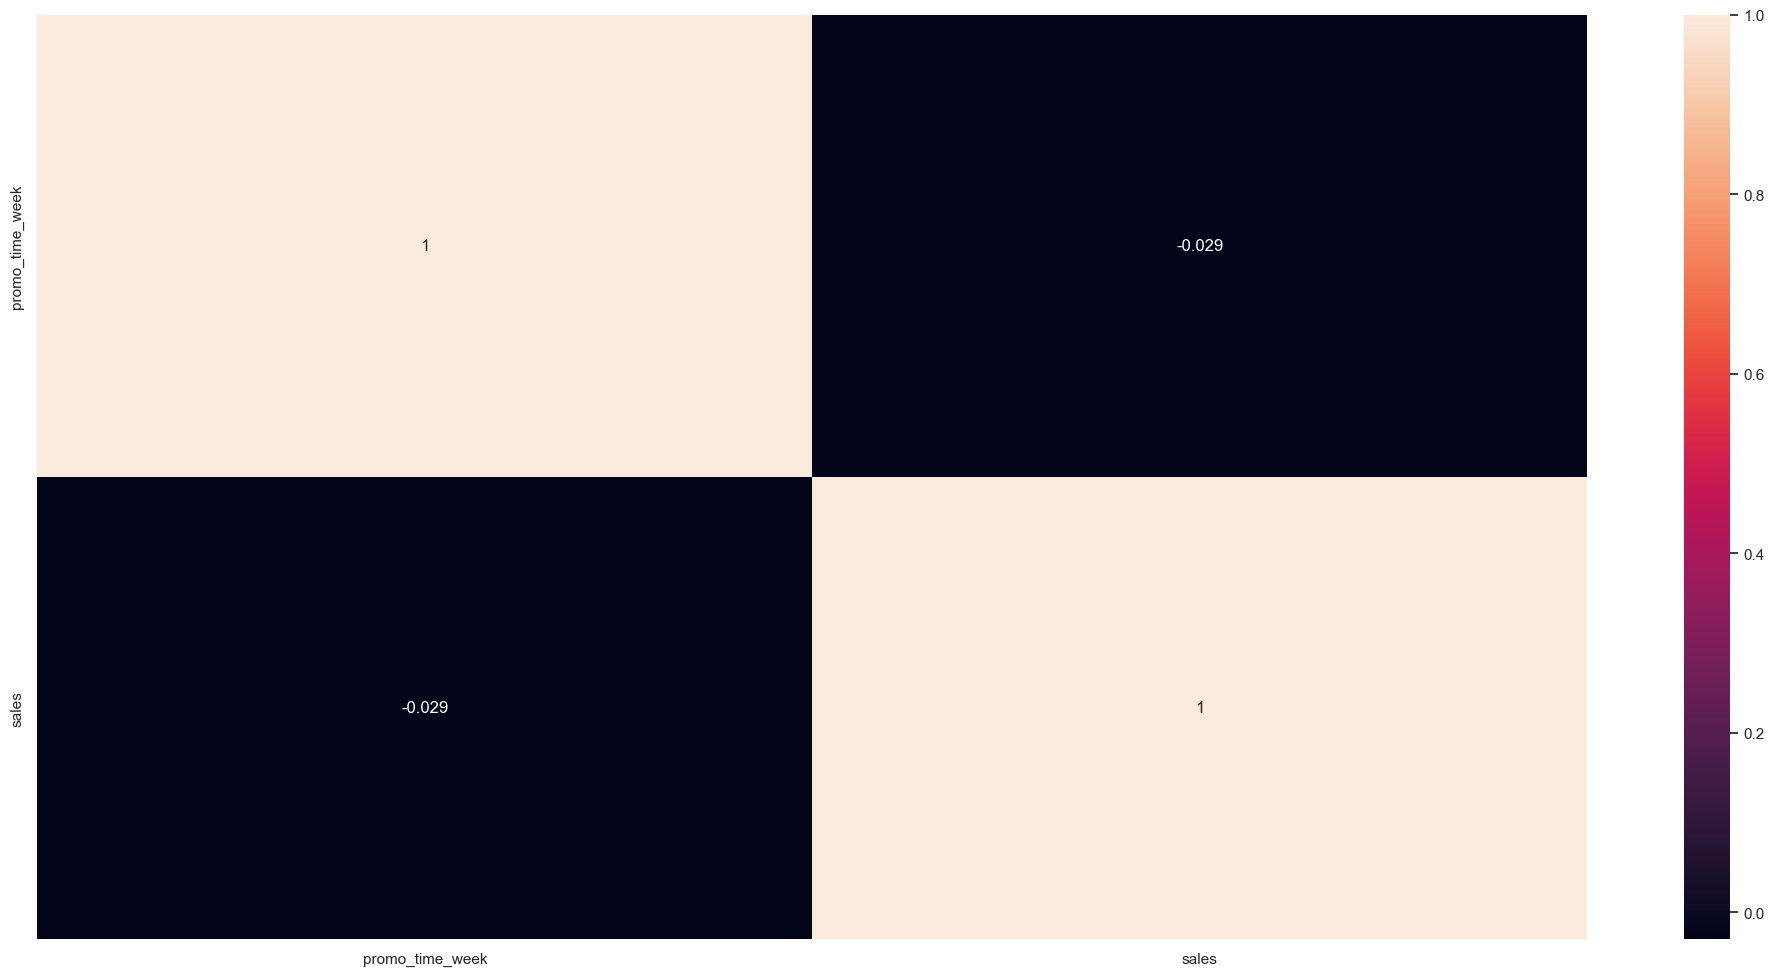

In [63]:
# Analisar a correlação

aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()
sns.heatmap( aux1.corr(method= 'pearson'), annot= True);

A correlação apresentada muito fraca, podendo ter influência da tendência

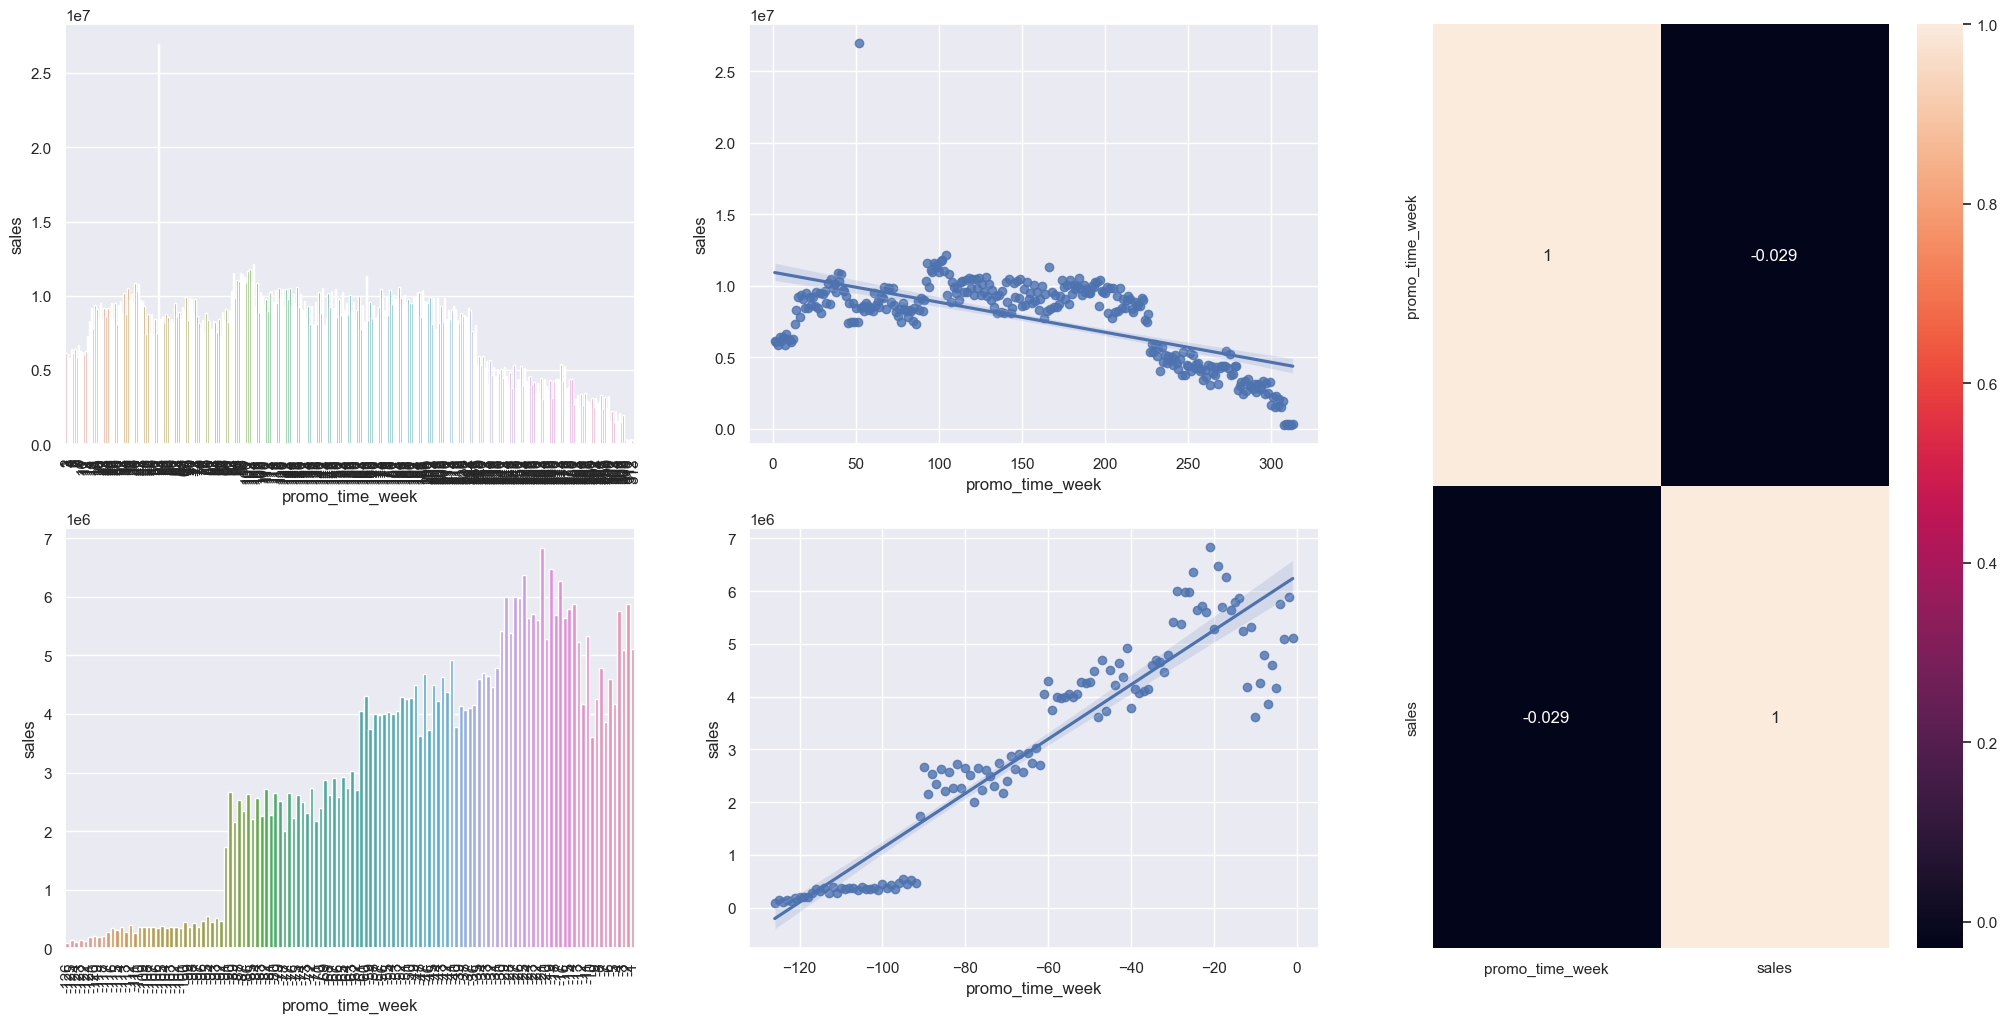

In [64]:
# Agrupando todas as análises

aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()

grid = GridSpec(2, 3)

# Promoção Estendida
plt.subplot(grid[0, 0])
aux2 = aux1[aux1['promo_time_week'] > 0 ]
sns.barplot(x = 'promo_time_week' , y = 'sales' , data = aux2);
plt.xticks(rotation = 90);

# RegPlot
plt.subplot(grid[0, 1])
sns.regplot(x = 'promo_time_week' , y = 'sales' , data = aux2);

# Promoção Tradicional
plt.subplot(grid[1, 0])
aux3 = aux1[aux1['promo_time_week'] < 0 ]
sns.barplot(x = 'promo_time_week' , y = 'sales' , data = aux3 );
plt.xticks(rotation = 90);

# RegPlot
plt.subplot(grid[1, 1])
sns.regplot(x = 'promo_time_week' , y = 'sales' , data = aux3 );

# Analisar a correlação
plt.subplot(grid[:, 2])
sns.heatmap( aux1.corr(method= 'pearson'), annot= True);

### <s>**H5.** Lojas com mais dias de promoção deveriam vender mais. </s>
- Similar a hipótese anterior. Necessário criar uma nova feature no dataframe **'promo_days'**, para fazer uma análise por loja. Iremos optar por realizar esse processo em uma próxima fase do CRISP-DS

### **H6.** Lojas com mais promoções consecutivas deveriam vender mais.
**FALSA** Lojas com mais promoções consecutivas vedem menos

Vamos assumir que Lojas com mais promoções consecutivas, seriam se as lojas entraram no período consecutivo de promoção.

In [71]:
df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).sum().reset_index().sort_values('sales', ascending=False)

,promo,promo2,sales
2,1,0,1628930532
0,0,0,1482612096
3,1,1,1472275754
1,0,1,1289362241


Podemos observar que as lojas que venderam mais não entraram na promoção estendida.

Será que ocorreu alguma mudança de comportamento ao longo do tempo?

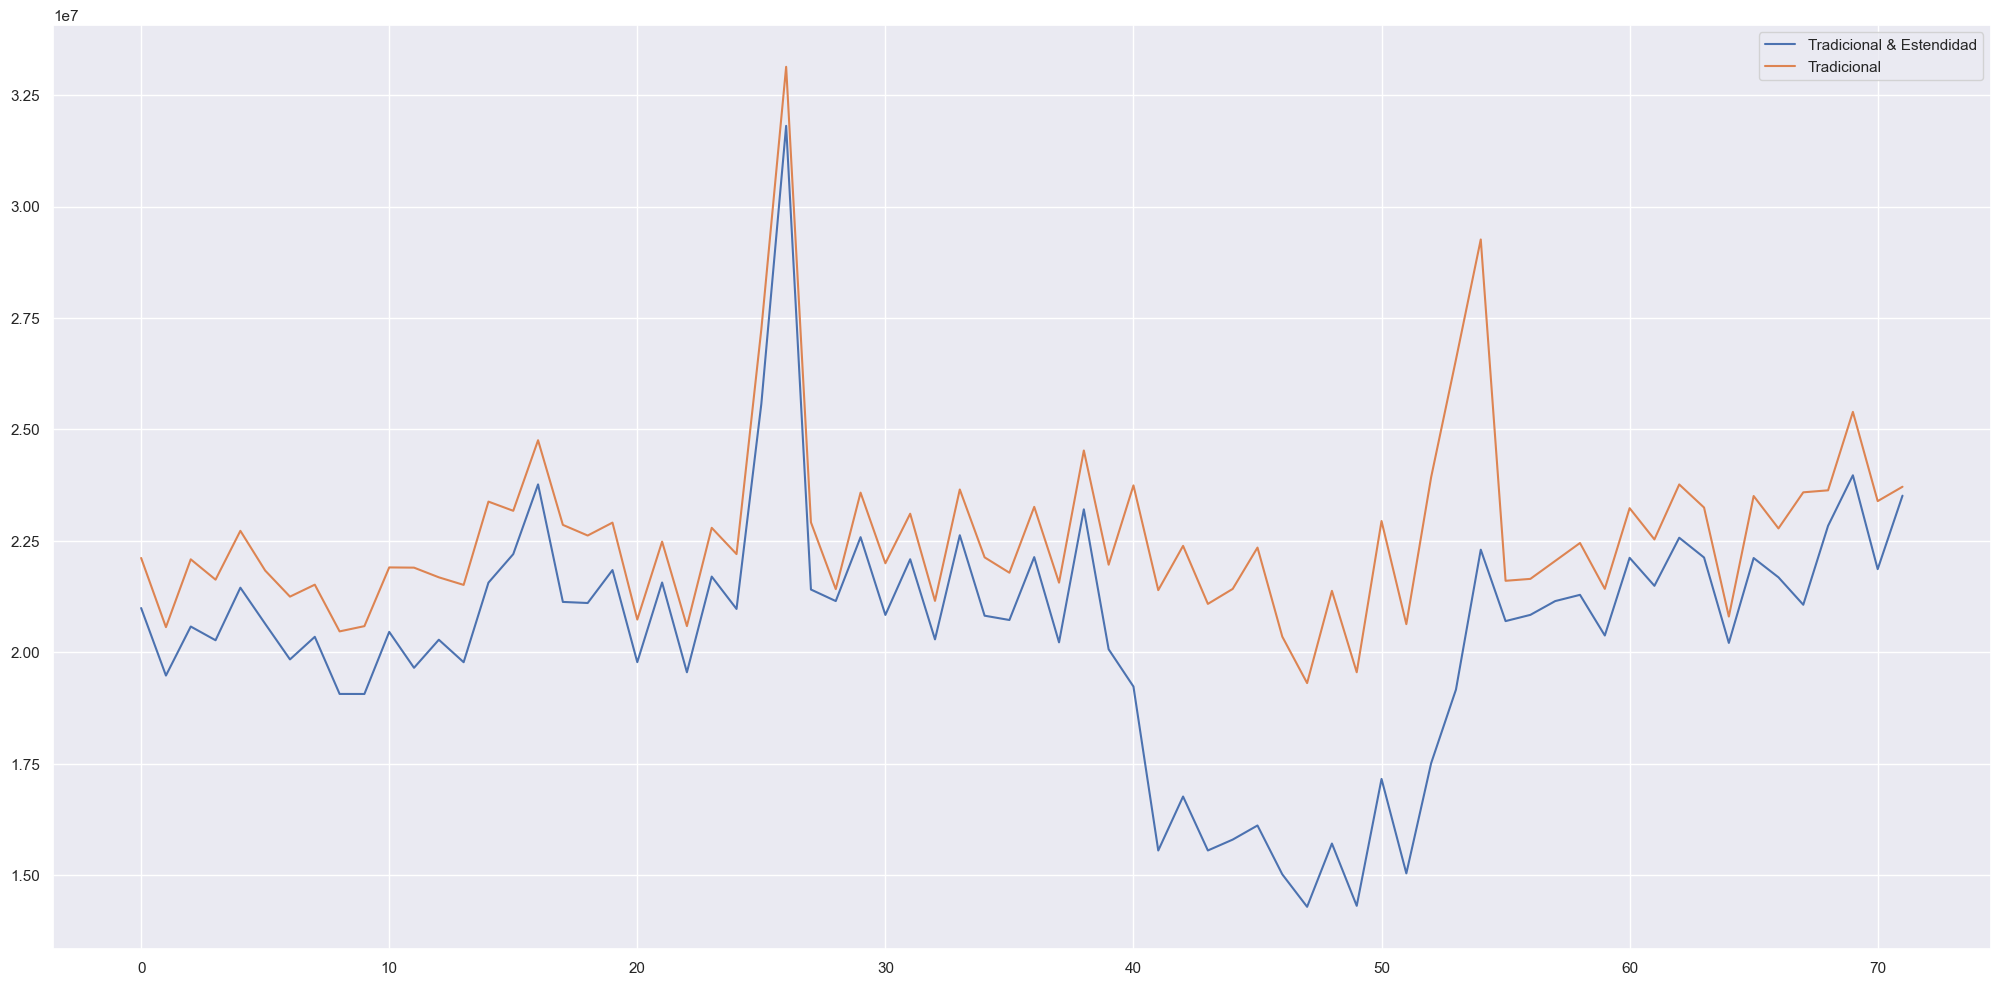

In [77]:
# Agrupar dados referente a lojas que participaram da Promoção Tradicional e Estendidas
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()

# Agrupar dados referente a lojas que participaram da Promoção Tradicional
aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').sum().reset_index()

# Organizando a plotagem
ax = aux1.plot()
aux2.plot( ax=ax)
ax.legend(labels = ['Tradicional & Estendidad', 'Tradicional']);

Observamos que o comportamento das lojas que participaram da **"Promoção Tradicional e Estendida"** e as que pariciparam somente da **"Promoção Tradicional"**, tem um comportamento similar, exceto em determinado momento que ocorreu um descolamento das linhas, onde as lojas que participaram de ambas as promoções sofreu uma queda acentuada.

Diante dessa análise, podemos assumir que a hipótese é falsa. Fica claro que as loja que participam de ambas não é maior que as que participaram somente da Tradicional

## 4.3. MULTIVARIATE ANALYSIS